# Part I - What Affects Lender's Contribution to Peer-to-peer Lending?  -- An Exploration on the Antecedants.
## by Jinyan Xiang

## Data Introduction

### The dataset is retrieved from Prosper.com - a leading p2p lending platform in the US. Borrowers on the platform can create loan listings seeking for p2p lending, and lenders can lend money to borrowers and gain interest as return. Data can be downloaded from  https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv.

### The original dataset contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others

## Data Processing (Preliminary Wrangling)

In [301]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn import preprocessing

%matplotlib inline

In [299]:
os.getcwd()

'/Users/jinyanxiang/Desktop/Data Science/Udacity/Data Analyst/Project 5_Prosper/Prosper'

In [3]:
#read the csv data
df_loan = pd.read_csv("prosperLoanData.csv")

In [4]:
#check the data information
print('data shape is:', df_loan.shape)
print('')
df_loan.info()

data shape is: (113937, 81)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null

In [5]:
#correct incorrect variable types
## 1. ListingNumber should be string (vs. integar)
## 2. ListingCreationDate and LoanOriginationDate should be timestamp (vs. object)

df_loan['ListingNumber'] = df_loan['ListingNumber'].astype('str')
df_loan['ListingCreationDate'] = pd.to_datetime(df_loan['ListingCreationDate'])
df_loan['LoanOriginationDate'] =pd.to_datetime(df_loan['LoanOriginationDate'])

In [6]:
#create a new variable -- 'LoanDuration' which measures how long a loan is funded
df_duration_diff = df_loan.LoanOriginationDate - df_loan.ListingCreationDate
df_loan['LoanDuration'] = df_duration_diff.apply(lambda x:(int(str(x).split(" ")[0])))

In [7]:
#create a new variable -- 'ListingYear'
df_loan['ListingYear'] = df_loan['ListingCreationDate'].apply(lambda x:x.year)

In [8]:
#createa new variable -- 'AverageLending' which measures the average amount per investor lent to a listing
df_loan['AverageLending'] = df_loan['LoanOriginalAmount']/df_loan['Investors']

In [9]:
#check duplicates of listings
df_loan['ListingNumber'].duplicated().value_counts()

False    113066
True        871
Name: ListingNumber, dtype: int64

In [10]:
#drop the duplicated listings 
df_loan.drop_duplicates(subset = ['ListingNumber'],inplace = True)

In [11]:
#recheck duplicates of listings
df_loan['ListingNumber'].duplicated().value_counts()

False    113066
Name: ListingNumber, dtype: int64

In [12]:
#drop not fully-funded listings
df_loan = df_loan.loc[df_loan['PercentFunded']==1.0]

In [13]:
#a specicial check on 'ProsperScore'
print(df_loan['ProsperScore'].isna().value_counts(),'\n')

#note that there are 29,083 missing values of ProsperScore (one of the focal predictors - elaborate it later)
#according to the data description, the significant amount of missing values is because Prosper Score are only applicable for listings listed after July 2009)
#however, listings prior July 2009 accounts for 26% of total listings, therefore, dropping all these listings causes a significant data loss
#keep these null values and address this issue later 
print('Listings prior July 2009 account for', "{0:.0%}".format(df_loan['ProsperScore'].isna().value_counts()[1]/df_loan.shape[0]), 'of total listings')

False    83113
True     29083
Name: ProsperScore, dtype: int64 

Listings prior July 2009 account for 26% of total listings


In [14]:
#find the time range for ListingCreationDate and LoanOriginationDate
print('the earliest creation date is', df_loan.ListingCreationDate.min())
print('the latest creation date is', df_loan.ListingCreationDate.max())

print('')

print('the earliest origination date is', df_loan.LoanOriginationDate.min())
print('the latest origination date is', df_loan.LoanOriginationDate.max())

the earliest creation date is 2005-11-09 20:44:28.847000
the latest creation date is 2014-03-10 12:20:53.760000

the earliest origination date is 2005-11-15 00:00:00
the latest origination date is 2014-03-12 00:00:00


In [15]:
#find the state information
state_list = np.sort(df_loan.BorrowerState.unique().astype(str))
state_list

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'nan'], dtype='<U3')

In [16]:
len(state_list) 

52

In [17]:
#recheck the data
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112196 entries, 0 to 113936
Data columns (total 84 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingKey                           112196 non-null  object        
 1   ListingNumber                        112196 non-null  object        
 2   ListingCreationDate                  112196 non-null  datetime64[ns]
 3   CreditGrade                          28952 non-null   object        
 4   Term                                 112196 non-null  int64         
 5   LoanStatus                           112196 non-null  object        
 6   ClosedDate                           54660 non-null   object        
 7   BorrowerAPR                          112172 non-null  float64       
 8   BorrowerRate                         112196 non-null  float64       
 9   LenderYield                          112196 non-null  float64       
 

-----------------------

## Data Structure and Exploration Questions

### Data Structure

#### 1. There are 112,196 unique fully-funded Prosper loan listings created and funded between Nov. 2005 and March 2014 in 51 US states and Washington DC.
#### 2. It contains 84 variables in various types (e.g., timestamp, integar, float, object and string), including three newly-create variables -- ```LoanDuration```, ```ListingYear```, and ```AverageLending```.

### What is/are the main feature(s) of interest in your dataset?

#### 1. I am primarily interested in factors that affect average lending amount (i.e., ```AverageLending```), which is calculated as  ```LoanOriginalAmount``` divided by ```Investors``` and reflects lender's contribution to p2p lending, a critical metrics p2p lending platforms are interested in.

#### 2. I am also interested in the listing distribution across years and states, which may reflect the popularity of p2p lending regionally and historically.

### Exploration Questions

#### 1. I expect <b> the borrower's </b> ```ProsperScore```, which is an integrated metric of the borrower's credibility and realibility, to have a positive effect on ```AverageLending```.
* See the source on how Prosper score is calculated: https://www.prosper.com/plp/general-prosper_score/

#### 2. I expect <b> the borrower's </b> ```StatedMonthlyIncome```, which suggests the borrower's payment ability, to have a positive effect on ```AverageLending```.

#### 3. I expect <b> the lender's </b> ```LenderYield```, which indicates expected financial return on lender's investment on a loan listing, to have a positive effect on ```AverageLending```.
* Although ```EstimatedEffectiveYield``` provides similiar information, it has around 30,0000 missing values; therefore, I focus on ```LenderYield```.

#### 4. I expect <b> the loan's </b> ```Term```, which affects rate of return and investment return period, to have a negative effect on ```AverageLending```.

#### 5. I expect <b> the loan's </b> ```LoanDuration```, to negatively correlate with ```AverageLending``` as the longer a list has been listed, the more risk investors may associate with the listing due to others' non-investing behaviors

#### 6. I expect<b> the loan's </b>  ```ListingYear``` to positively correlate with ```AverageLending``` as people become more familiar with and perceive a lower risk of p2p lending.

#### 7. I expect p2p lending to be more popular in more recent years.

#### 8. I expect p2p lending to be more popular in states (i.e., ```BorrowerState```) with better economies (e.g., CA, TX, NY -- states with the highest GDP).

## Univariate Exploration

In [18]:
#create a new dataframe that contains variables in interest and neccessary additional information
new_vars = ['ListingNumber', #unique listing identifiers
            'ListingKey', #unique identifiers in API
            'MemberKey', #Unique identifiers for the borrower
            'AverageLending', #focal outcome variable
            'ProsperScore','StatedMonthlyIncome', #focal predictors - borrower-related
            'LenderYield', #focal predictors - lender-related
            'Term','LoanDuration',#focal predictors - loan-related
            'ListingYear','BorrowerState', #year/state info
            'ListingCreationDate','LoanOriginationDate','LoanOriginalAmount','Investors'] #variables used for calculation

In [19]:
df_exp = df_loan[new_vars]

In [20]:
#check df_exp info
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112196 entries, 0 to 113936
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ListingNumber        112196 non-null  object        
 1   ListingKey           112196 non-null  object        
 2   MemberKey            112196 non-null  object        
 3   AverageLending       112196 non-null  float64       
 4   ProsperScore         83113 non-null   float64       
 5   StatedMonthlyIncome  112196 non-null  float64       
 6   LenderYield          112196 non-null  float64       
 7   Term                 112196 non-null  int64         
 8   LoanDuration         112196 non-null  int64         
 9   ListingYear          112196 non-null  int64         
 10  BorrowerState        106682 non-null  object        
 11  ListingCreationDate  112196 non-null  datetime64[ns]
 12  LoanOriginationDate  112196 non-null  datetime64[ns]
 13  LoanOriginalAm

In [21]:
df_exp.describe()

,AverageLending,ProsperScore,StatedMonthlyIncome,LenderYield,Term,LoanDuration,ListingYear,LoanOriginalAmount,Investors
count,112196.000000,83113.000000,1.121960e+05,112196.000000,112196.000000,112196.000000,112196.000000,112196.000000,112196.000000
mean,2833.388288,5.947565,5.597247e+03,0.182670,40.773432,11.078559,2010.991871,8306.296053,80.331589
std,5714.121998,2.375420,7.505038e+03,0.074496,10.405176,27.408318,2.514504,6244.667504,103.234013
min,7.299270,1.000000,0.000000e+00,-0.010000,12.000000,0.000000,2005.000000,1000.000000,1.000000
25%,54.347826,4.000000,3.196563e+03,0.124375,36.000000,4.000000,2008.000000,4000.000000,2.000000
50%,97.222222,6.000000,4.666667e+03,0.173000,36.000000,7.000000,2012.000000,6100.000000,44.000000
75%,2000.000000,8.000000,6.791479e+03,0.240000,36.000000,12.000000,2013.000000,12000.000000,115.000000
max,35000.000000,11.000000,1.750003e+06,0.492500,60.000000,1094.000000,2014.000000,35000.000000,1189.000000


In [22]:
#although BorrowerState has null values, it is not predicted to affect the focal outcome variable -- 'AverageLending', therefore, keep these null values for now and address when using this variable
#ProspersScore has null values too but keep these null values for now too (rationales has been elucidated)

In [23]:
#set up the graph theme
sns.set_theme(style="white", palette="pastel")

In [302]:
df_exp.to_csv('df_exp.csv')

### Questions 1 - 6: what are the distributions of the focal outcome variable (i.e., ```AverageLending```) and continous (quantitative) predictors (i.e., ```ProspserScore```,```StatedMonthlyIncome```,```LenderYield```,```LoanDuration```)

### Virsualization 1: Box plots for the distributions of these variables to check outliers

In [24]:
df_exp.loc[df_exp['ProsperScore'].isna()==False]['ProsperScore'].min()

1.0

In [305]:
#the goal is to draw box plots of these variables in one chart, however, these variables have different scales. Thererefore, the first step is to rescale these data into a [0,1] range.

con_var_normed_list = []
con_var_list = ['AverageLending','ProsperScore','StatedMonthlyIncome','LenderYield','LoanDuration']

for var in con_var_list:
    df_nas = df_exp.loc[df_exp[var].isna()==False]
    var_self = df_nas[var]
    var_min = var_self.min()
    var_max = var_self.max()
    
    var_norm = np.round((var_self - var_min)/(var_max-var_min),2)
    con_var_normed_list.append(var_norm)

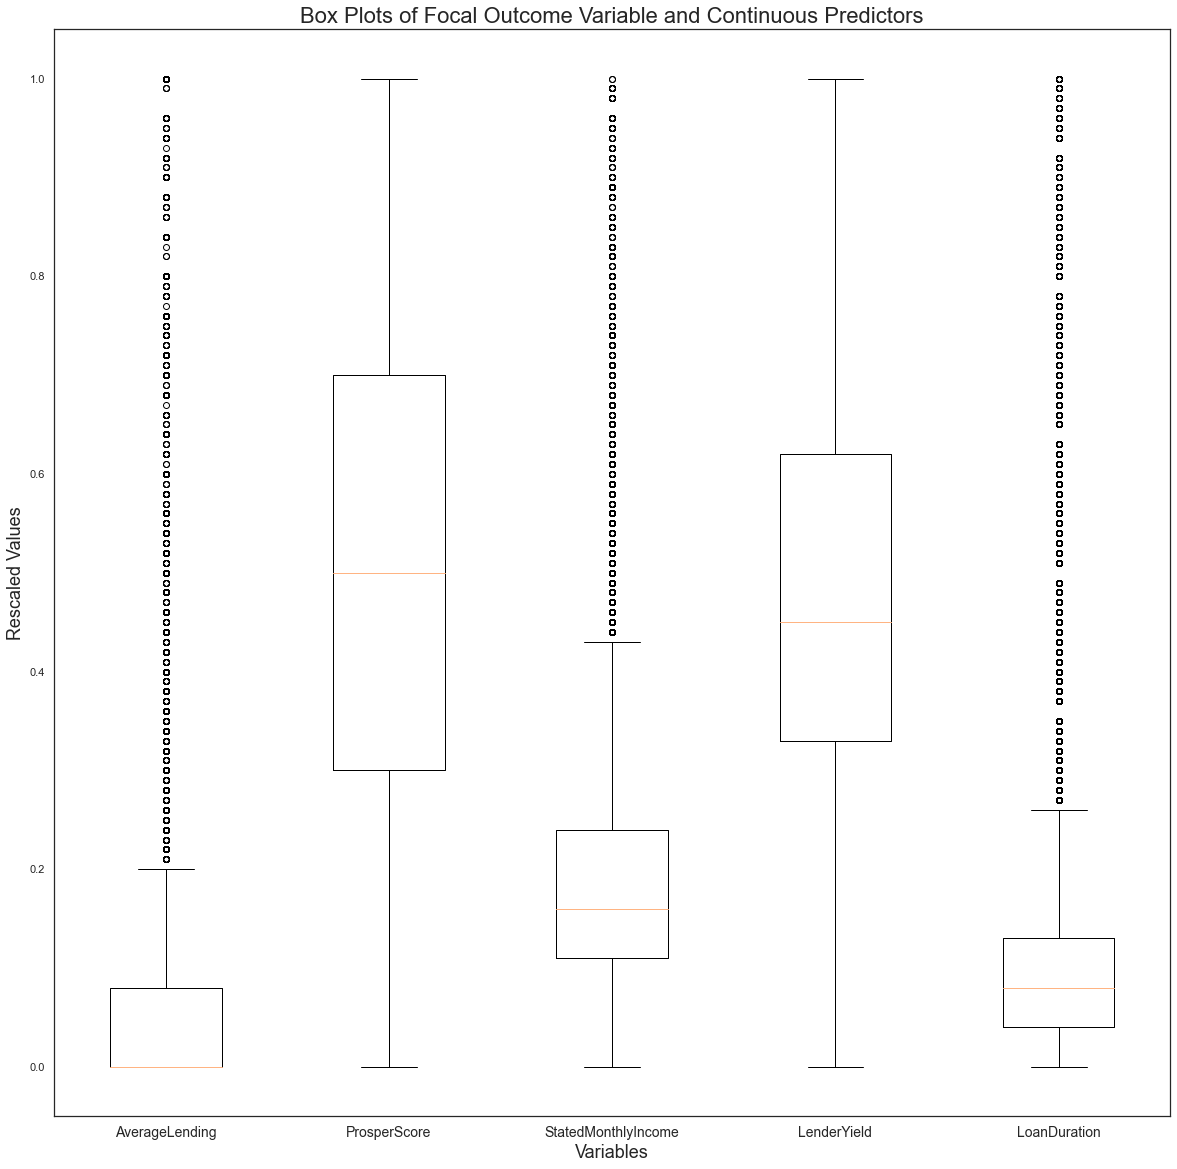

In [306]:
#draw the boxplot
fig, ax = plt.subplots(figsize=[20, 20])
ax.boxplot(con_var_normed_list)

#add descriptions
ax.set_title ('Box Plots of Focal Outcome Variable and Continuous Predictors',fontsize = 22, ha = 'center')

ax.set_xlabel('Variables', fontsize = 18, ha = 'center')
ax.set_ylabel('Rescaled Values', fontsize = 18, ha = 'center')

ax.set_xticks([1,2,3,4,5],con_var_list,fontsize = 14, rotation = 0)


plt.show()

#### Observation 1.1: Figure 1 shows that there are extreme outliers for ```AverageLending```, ```StatedMonthlyIncome```, ```LenderYield```, and ```LoanDuration```, suggesting a deeper investigation into these outliers need to be conducted prior further exploration.

In [27]:
#check general information for these variables
df_exp[con_var_list].describe()

,AverageLending,ProsperScore,StatedMonthlyIncome,LenderYield,LoanDuration
count,112196.000000,83113.000000,1.121960e+05,112196.000000,112196.000000
mean,2833.388288,5.947565,5.597247e+03,0.182670,11.078559
std,5714.121998,2.375420,7.505038e+03,0.074496,27.408318
min,7.299270,1.000000,0.000000e+00,-0.010000,0.000000
25%,54.347826,4.000000,3.196563e+03,0.124375,4.000000
50%,97.222222,6.000000,4.666667e+03,0.173000,7.000000
75%,2000.000000,8.000000,6.791479e+03,0.240000,12.000000
max,35000.000000,11.000000,1.750003e+06,0.492500,1094.000000


In [28]:
#define a function for checking 1 and 99 percentiles, as well as M plus or minus 3SD to determine the cutoff line of extreme ouliters (whichever is more extreme and above min or max)

def OutlierCutoff(var):
    p_99 = np.percentile(df_exp[var],99)
    p_1 = np.percentile(df_exp[var],1)
    
    Mminus3SD = df_exp[var].mean()-df_exp[var].std()*3
    Mplus3SD = df_exp[var].mean()+df_exp[var].std()*3
    
    Min = df_exp[var].min()
    Max = df_exp[var].max()
    
    if min([Mminus3SD,p_1]) < Min:
        cutoff_low = Min
    else:
        cutoff_low = min([Mminus3SD,p_1])
    
    if max([Mplus3SD,p_99]) < Max:
        cutoff_high = max([Mplus3SD,p_99])
    else: 
        cutoff_high = Max
    
    print('cutoff_low: ', cutoff_low)
    print('cutoff_high: ', cutoff_high)
    print('')
    print('1 percentile:', p_1,'',
          'M-3SD: ', Mminus3SD,''
          'min: ',Min)
    print('99 percentile:', p_99,'',
          'M+3SD: ', Mplus3SD,'',
          'max: ',Max)

In [29]:
df_exp.StatedMonthlyIncome

0         3083.333333
1         6125.000000
2         2083.333333
3         2875.000000
4         9583.333333
             ...     
113932    4333.333333
113933    8041.666667
113934    2875.000000
113935    3875.000000
113936    4583.333333
Name: StatedMonthlyIncome, Length: 112196, dtype: float64

In [30]:
#determine the outlier cutoff points for AverageLending
OutlierCutoff('AverageLending')

cutoff_low:  7.299270072992701
cutoff_high:  25000.0

1 percentile: 18.91891891891892  M-3SD:  -14308.977704076626 min:  7.299270072992701
99 percentile: 25000.0  M+3SD:  19975.754280972636  max:  35000.0


In [31]:
#determine the outlier cutoff points for StatedMonthlyIncome
OutlierCutoff('StatedMonthlyIncome')

cutoff_low:  0.0
cutoff_high:  28112.361137342836

1 percentile: 0.0  M-3SD:  -16917.86666189837 min:  0.0
99 percentile: 20416.666667  M+3SD:  28112.361137342836  max:  1750002.916667


In [32]:
#determine the outlier cutoff points for LenderYield
OutlierCutoff('LenderYield')

cutoff_low:  -0.01
cutoff_high:  0.4061592202679776

1 percentile: 0.0549  M-3SD:  -0.04081906910395133 min:  -0.01
99 percentile: 0.34  M+3SD:  0.4061592202679776  max:  0.4925


In [33]:
#determine the outlier cutoff points for LoanDuration
OutlierCutoff('LoanDuration')

cutoff_low:  0
cutoff_high:  93.30351401174617

1 percentile: 1.0  M-3SD:  -71.14639611092976 min:  0
99 percentile: 73.0  M+3SD:  93.30351401174617  max:  1094


In [34]:
#per checking results, drop outliers (all at the upper bound):
def DropOutliers(var,cutoff):
    df_exp.drop(df_exp.loc[df_exp[var] > cutoff].index, inplace = True)
    return df_exp.shape

In [35]:
#drop outliers of AverageLending
DropOutliers('AverageLending',25000)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(111755, 15)

In [36]:
#drop outliers of AverageLending
DropOutliers('StatedMonthlyIncome',28104)

(111359, 15)

In [37]:
#drop outliers of LenderYield
DropOutliers('LenderYield',0.41)

(111353, 15)

In [38]:
#drop outliers of LoanDuration
DropOutliers('LoanDuration',93)

(110579, 15)

In [39]:
#recheck the time range for ListingCreationDate and LoanOriginationDate
print('the UPDATED earliest creation date is', df_exp.ListingCreationDate.min())
print('the UPDATED latest creation date is', df_exp.ListingCreationDate.max())

print('')

print('the UPDATED earliest origination date is', df_exp.LoanOriginationDate.min())
print('the UPDATED latest origination date is', df_exp.LoanOriginationDate.max())

the UPDATED earliest creation date is 2005-11-09 20:44:28.847000
the UPDATED latest creation date is 2014-03-10 12:20:53.760000

the UPDATED earliest origination date is 2005-11-15 00:00:00
the UPDATED latest origination date is 2014-03-12 00:00:00


In [40]:
np.sort(df_exp.BorrowerState.unique().astype(str))

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'nan'], dtype='<U3')

In [41]:
len(np.sort(df_exp.BorrowerState.unique().astype(str)))

52

#### Observation 1.2: After the further data proccessing (i.e., dropping extreme outliers of the outcome variable and countinous focal predictors), we have 110,579 unique listings between Nov 2005 to March 2014 in 51 States and Washington DC. This new dataframe will be used for further exlporation of the distributions.

### Virsualization 2-6: Histograms for the distributions of these variables

In [42]:
#define a function for drawing histograms for distributions
def Hist(var, binsize, var_name, fig_num):
    plt.figure(figsize=[20, 10])
    
    sns.histplot(data = df_exp, x = var ,bins = binsize)
    
    min_x = df_exp[var].min()
    max_x = df_exp[var].max()
    
    plt.xlim = ([min_x,max_x])
    
    plt.xlabel(var_name, fontsize = 18)
    plt.ylabel('Frequency', fontsize = 18)
    
    title = 'Figure ' + fig_num + ': ' + 'Distribution of ' + var_name
    plt.title(title, fontsize = 22)
    
    return plt.show()

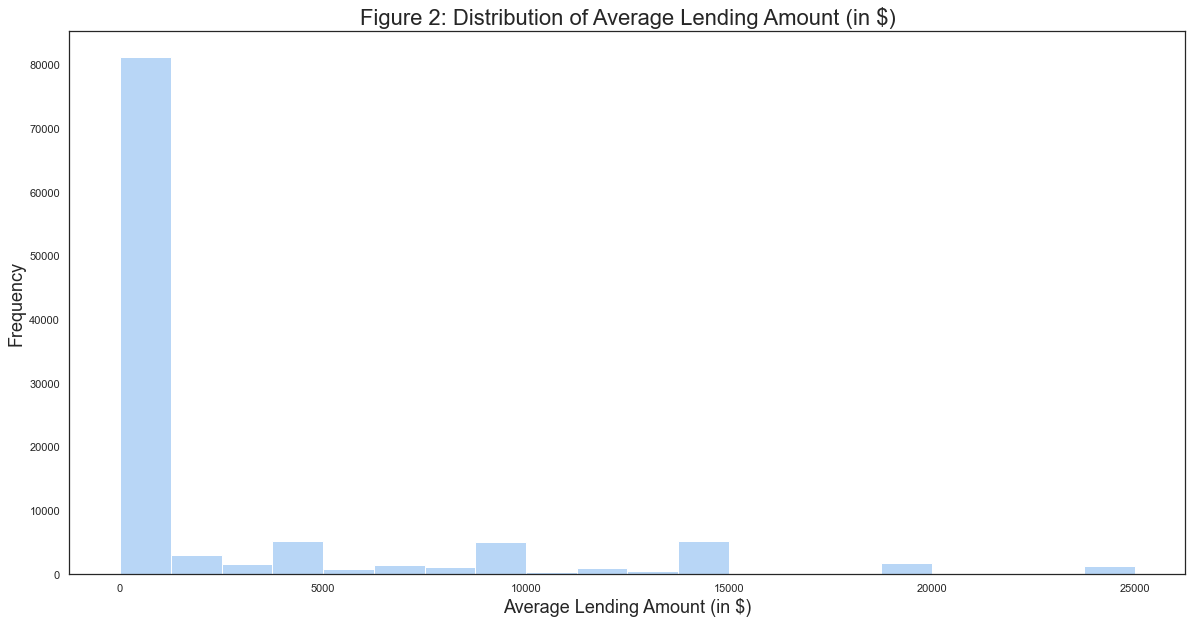

In [43]:
#Figure 2: histogram of loan original amount
var2 = 'AverageLending'
binsize2 =  20
var_name2 = 'Average Lending Amount (in $)'
fig_num2 = '2'

Hist(var2, binsize2, var_name2, fig_num2)

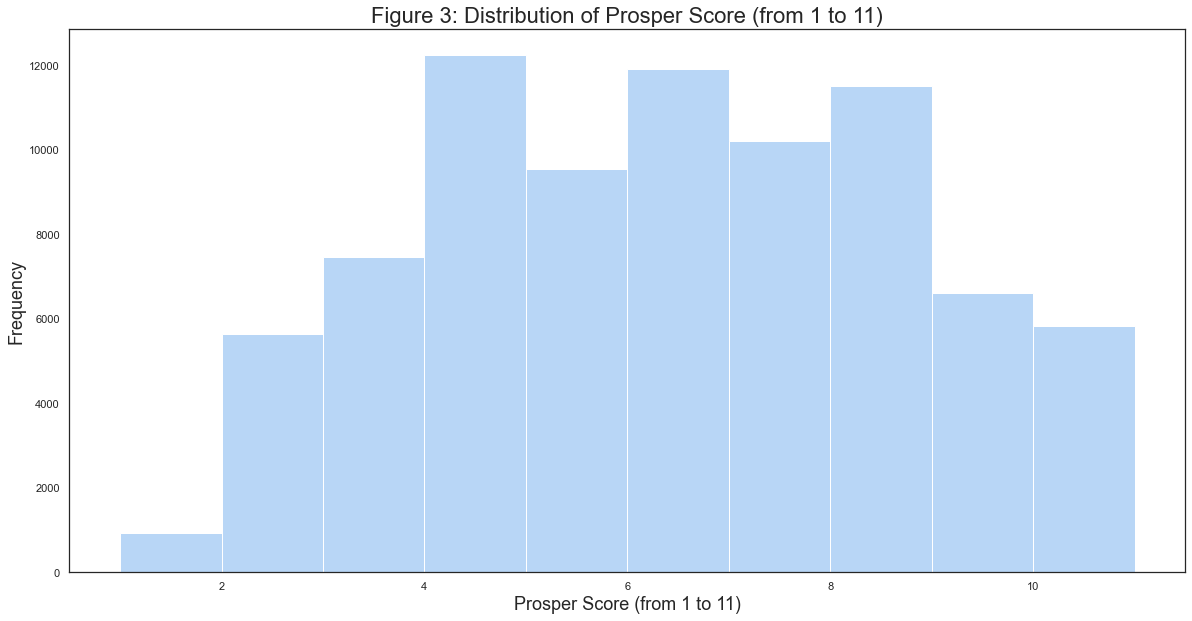

In [44]:
#Figure 3: histogram of Prosper Score
var3 = 'ProsperScore'
binsize3 = 10

var_name3 = 'Prosper Score (from 1 to 11)'
fig_num3 = '3'

Hist(var3, binsize3, var_name3, fig_num3)

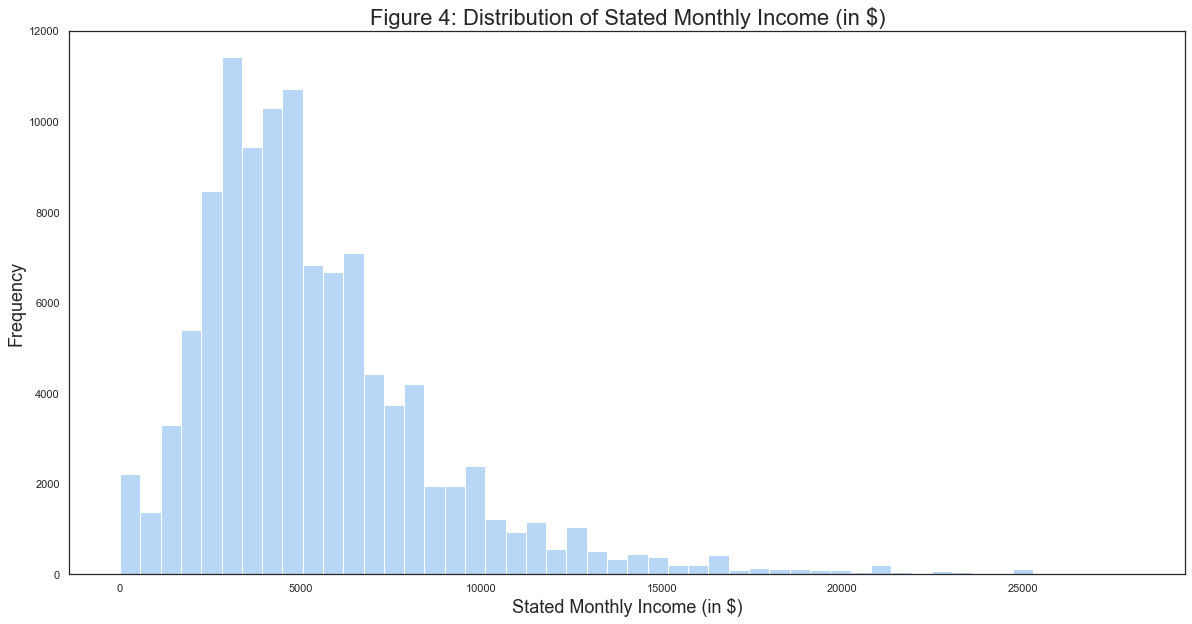

In [45]:
#Figure 4: histogram of Stated Monthly Income
var4 = 'StatedMonthlyIncome'
binsize4 = 50
var_name4 = 'Stated Monthly Income (in $)'
fig_num4 = '4'

Hist(var4, binsize4, var_name4, fig_num4)

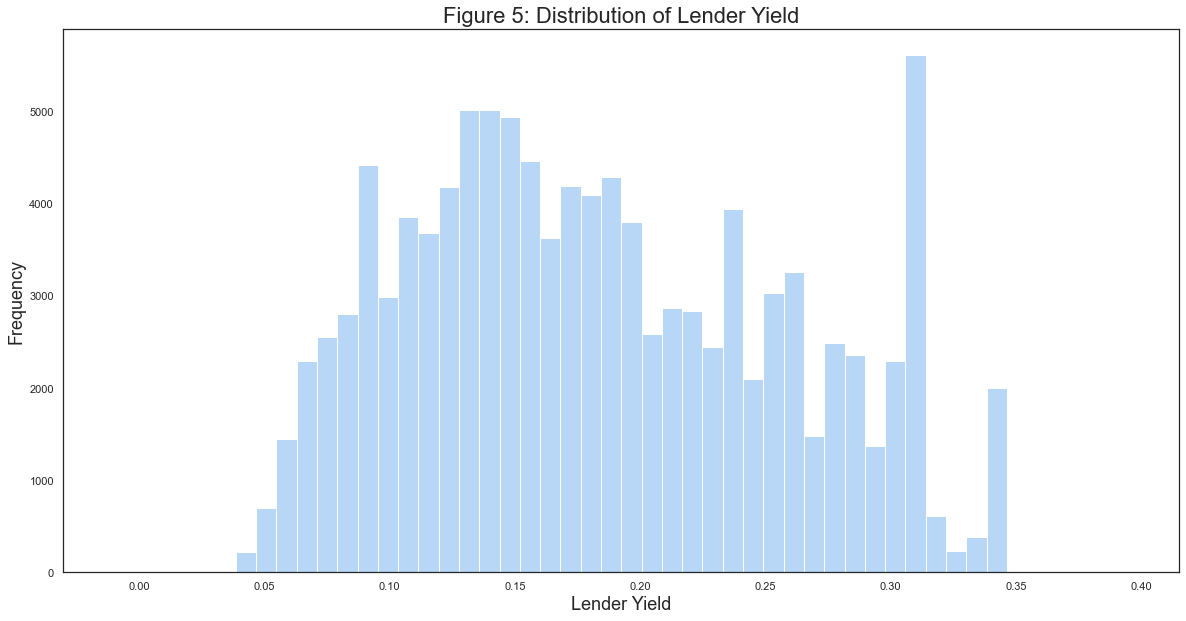

In [46]:
#Figure 5: histogram of Lender Yield
var5 = 'LenderYield'
binsize5 = 50
var_name5 = 'Lender Yield'
fig_num5 = '5'

Hist(var5, binsize5, var_name5, fig_num5)

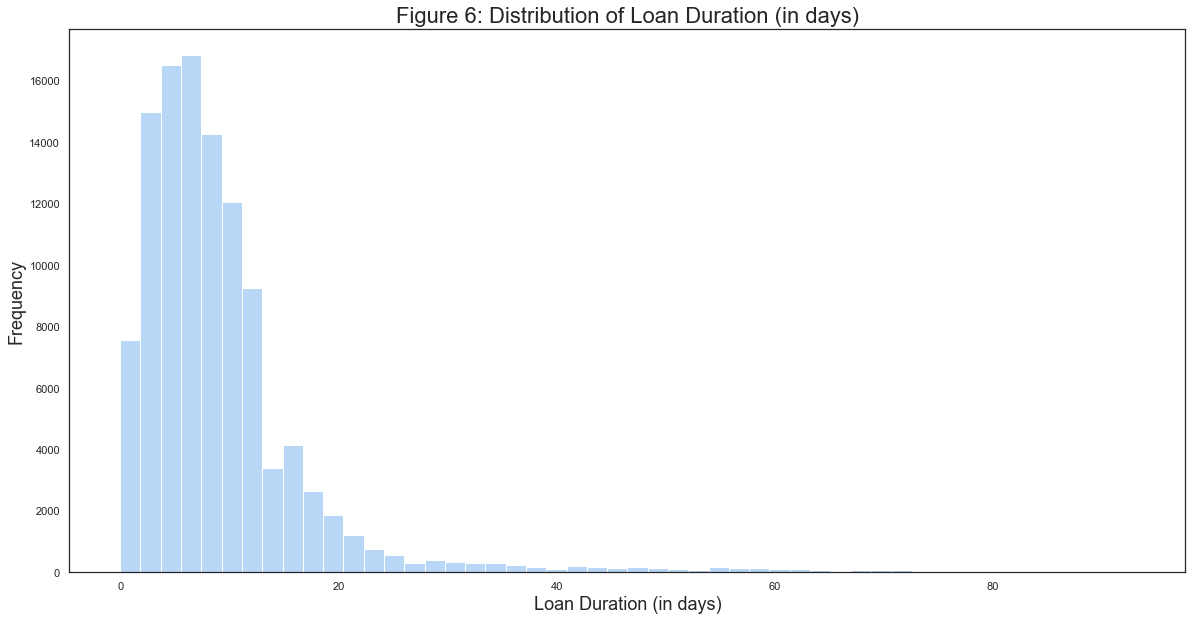

In [47]:
#Figure 6: histogram of Loan Duration
var6 = 'LoanDuration'
binsize6 = 50
var_name6 = 'Loan Duration (in days)'
fig_num6 = '6'

Hist(var6, binsize6, var_name6, fig_num6)

### Virsualization 7-8: Bar Plots for the distributions of categorical (i.e.. ```Term```) and discrete (i.e., ```ListingYear```) predictors  

In [48]:
#define a function for draw bar plots for distributions
def Bar(var, var_name, fig_num, rotation):
    plt.figure(figsize=[20, 10])
    
    df_temp = df_exp[var].value_counts().rename_axis(var).reset_index(name = 'Counts').sort_values(by = var)
    
    ax = sns.barplot(data = df_temp, x = var, y = 'Counts')
    
    plt.xlabel(var_name, fontsize = 18)
    plt.ylabel('Frequency', fontsize = 18)
    plt.xticks(range(len(list(df_temp[var]))), list(df_temp[var]), rotation = rotation, fontweight = 'bold', fontsize = 14)
    
    title = 'Figure ' + fig_num + ': ' + 'Distribution of ' + var_name
    plt.title(title, fontsize = 22)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(x = p.get_x()+(p.get_width()/2),
                y = height+100,
                s = '{:.0f}'.format(height),
                fontsize= 12,
                ha = 'center') 
    
    return plt.show()

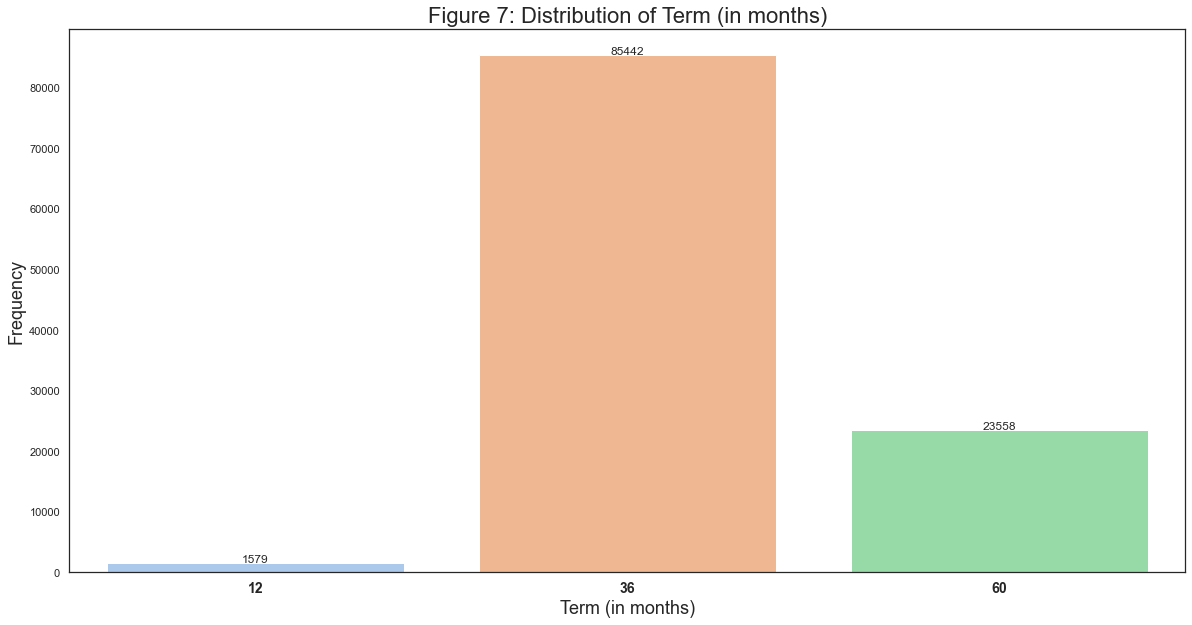

In [49]:
#Figure 8: bar chart for Term
var7 = 'Term'
var_name7 = 'Term (in months)'
fig_num7 = '7'
rotation7 = 0

Bar(var7, var_name7, fig_num7, rotation7)

In [50]:
#calcualtions
print ('36-month term accounts for' ,"{0:.0%}".format(85442/df_exp.shape[0]))
print ('')
print ('60-month term accounts for' ,"{0:.0%}".format(23558/df_exp.shape[0]))

36-month term accounts for 77%

60-month term accounts for 21%


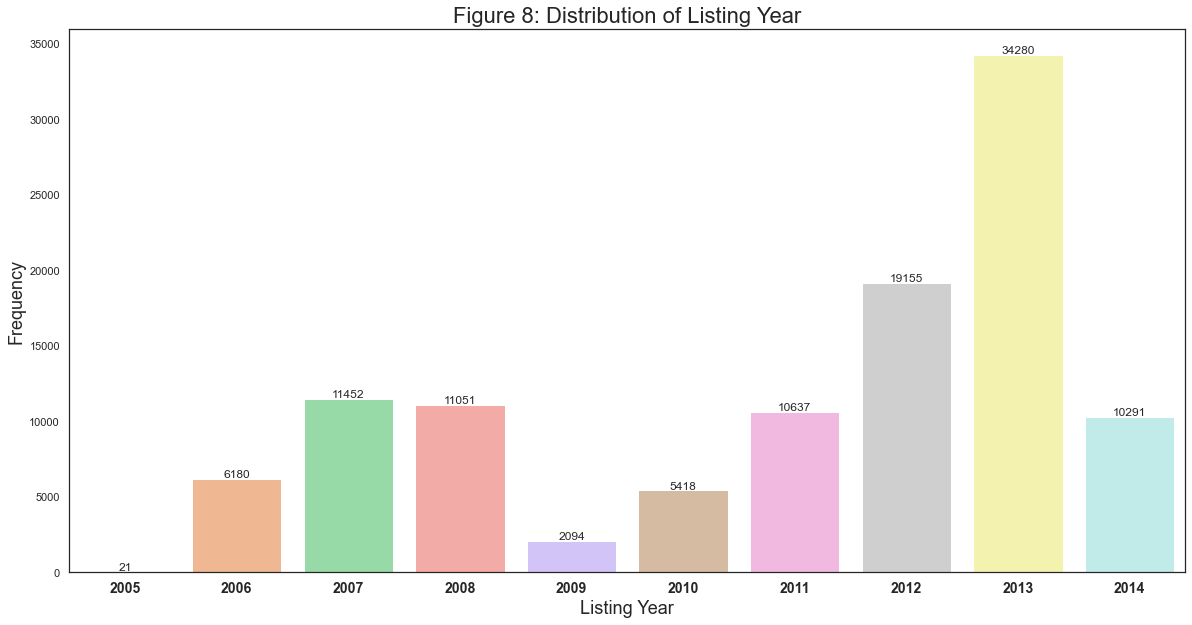

In [51]:
#Figure 8: bar chart for ListingYear 
var8 = 'ListingYear'
var_name8 = 'Listing Year'
fig_num8 = '8'
rotation8 = 0

Bar(var8, var_name8, fig_num8, rotation8)

## Findings of  Univariate Exploration

### 1. The box plots (Figure 1) shows that the focal outcome variable (i.e., ```AverageLending```) and some continuous (quantitative) predictors (```StatedMontlyIncome```,```LenderYield```,```LoanDuration```) have extreme outliers. Therefore, I determined the outlier cutoff point (criteria: mean minus/plus three standardized deviations or the 1/99 percentile whichever is greater/smaller) and removed outliers based on the cutoff points.

### 2. After removing these extereme outliers, the histograms (Figure 2 to 6) shows that the focal outcome variable and continuous predictors not still normally distributed. Instead:
  #### 2.1. ```ProsperScore``` is closest to a normal distribution, which does not need further transformation for further visualization and statistical analysis.
  #### 2.2. ```LenderYield``` are close to normal distribution but the mode is deviating from the mean and median. Transformation and advanced regression model that does not require normal distribution are desirable for statistical analysis. 
  #### 2.3. ```MonthlyStatedIncome```and```LoanDuration``` and are highly right skewed. Such distributions suggest log transformation is necessary prior any statistical analysis. Advanced estimation methods (e.g., robust SE) and advanced regression model (e.g., generalized linear model) that can further address skewness and potential heteroskedasticity are also desirable
  #### 2.4. The distribution of ```AverageLending``` is more irregular.  Transformation and advanced regression model that does not require normal distribution are required for statistical analysis.

### 3. The bar chart of Loan Term (Figure 7) shows that the majority of the listings have a 36-month term (77%) and about one fifth of the listings have 60-month terms.

### 4. The bar chart of Listing Year (Figure 8) show that there was a dramatic increase in listings since 2011, almost doubling every year. Note that only 3-month of listing data were included for 2014, and thus the decrease in listings in 2014 was spurious, which will be addresssed later.

### 5. Except for drawing regression plot and correaltion plots (which will be biased by skewness and irregular distributions), I prefer not to do further transformation on the data for visualization which does not require a specific distribution, because plotting with raw data will be more straightforward for interpretation

## Bivariate Exploration

### Question 9-10: What are the correlations between each pair of the focal outcome variable and quantitative predictors?

### Virsualization 9: Correlation plots for each pair of the focal outcome variables and quantitative predictors

In [52]:
#Figure 9 correlation plot for these variables
##before drawing the correlation plot, take log transformation of all variables first for less biased correlation coefficients
con_var_list = ['AverageLending','ProsperScore','StatedMonthlyIncome','LenderYield','LoanDuration']

df_temp1 = df_exp[con_var_list].copy()

for var in con_var_list:
    var_self = df_temp1[var]
    var_log = np.log(var_self+0.5) #+1 to avoid 0s
    new_var = var+'_log'
    
    df_temp1[new_var] = var_log

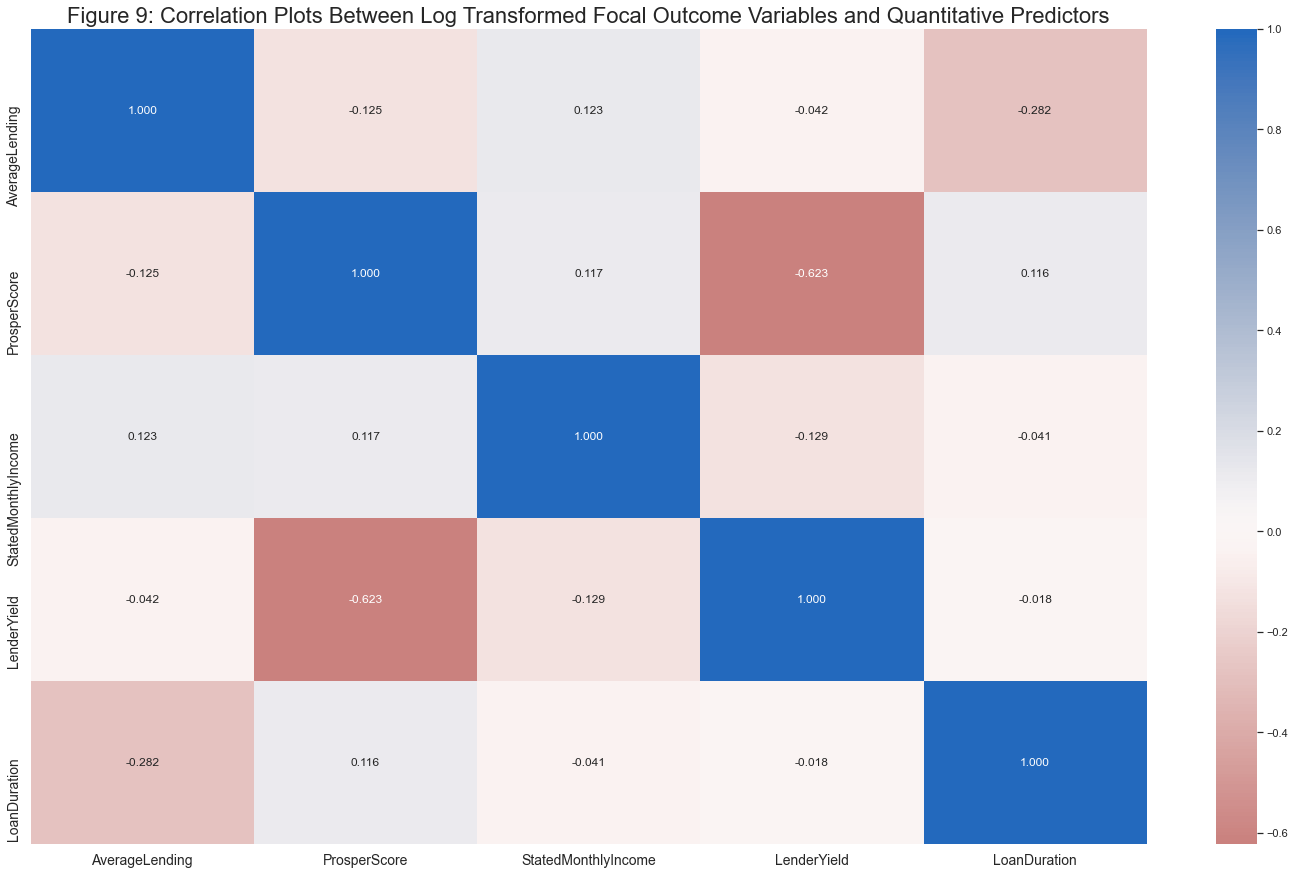

In [53]:
##draw the correlation plot
con_var_list_new = list(map(lambda x:x+'_log',con_var_list))

plt.figure(figsize = [25, 15])
plt.title("Figure 9: Correlation Plots Between Log Transformed Focal Outcome Variables and Quantitative Predictors", fontsize = 22)
sns.heatmap(df_temp1[con_var_list_new].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)

plt.xticks([0.5,1.5,2.5,3.5,4.5],con_var_list,fontsize = 14)
plt.yticks([0.5,1.5,2.5,3.5,4.5],con_var_list,fontsize = 14)

plt.show()

### Virsualization 10: Scatter plots Maxtrix for each pair of the focal outcome variables and quantitative predictors

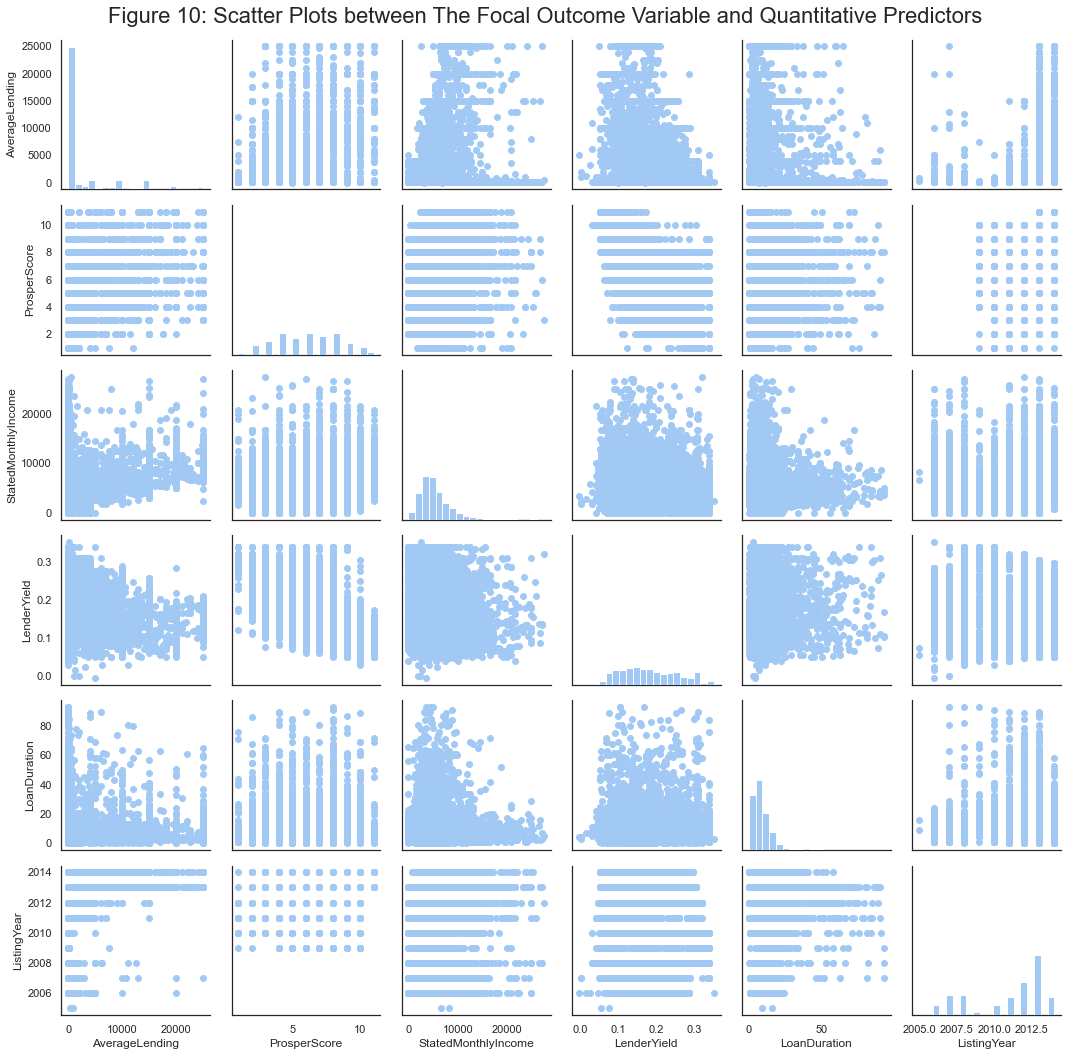

In [54]:
#draw a matrix for overviewing the scatter plots between AverageLending and all continuous predictors (plus Listingyear, which can be treated as continuous) with 1,000 random sampling (about 10%))
df_exp_samp = df_exp.sample(n=10000, replace = False)



g = sns.PairGrid(data = df_exp_samp, vars = ['AverageLending','ProsperScore','StatedMonthlyIncome','LenderYield','LoanDuration','ListingYear']) #raw data (vs. log transformed data were used)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Figure 10: Scatter Plots between The Focal Outcome Variable and Quantitative Predictors', fontsize = 22)

plt.show()

### Observation 9-10: The correlation matrix and scatter plot maxtrix show that:
#### 1. ```AverageLending``` is positively correlated with ```StatedMonthlyIncome``` and negatively correlated with ```LoanDuration```, which are consistent with predictions.
#### 2. Suprisingly, ```ProsperScore``` is negatively correlated with ```AverageLending```. However, the scatter plot suggests that ProsperScore may be better treated as a discrete variable (vs. continuous variable) as it is measured descretely.
#### 3. ```LenderYield``` has a very weak negative impact on ```AverageLending```.
#### 4. The scatter plot provides little information about how ```Term``` is affected ```AverageLending```, as it is a categorical variable, therefore, additional exploration are needed
#### 5. The scatter plot provides preliminary evidence that  ```AverageLending``` increases by year when treating it as a continuous variable, however, additional exploration are needed.

### Question 11-12: What are the relationship between the focal outcome variable (i.e., ```Term```) and categorical and discrete (i.e., ```ListingYear```,```ProsperScore```) predictors?

### Virsualizaton 11: Box Plots of Categorical and Discrete Predictor against the Focal Outcome Variable 

In [55]:
#Figure 11 box plots to s plot the categorical and discrete predictors (i.e., Term, ListingYear) against raw and log transformed AverageLending
##before drawing the box plots, first add the log values to the original df_exp

df_exp2 = df_exp.join(df_temp1[con_var_list_new])
df_exp2.head()

,ListingNumber,ListingKey,MemberKey,AverageLending,ProsperScore,StatedMonthlyIncome,LenderYield,Term,LoanDuration,ListingYear,BorrowerState,ListingCreationDate,LoanOriginationDate,LoanOriginalAmount,Investors,AverageLending_log,ProsperScore_log,StatedMonthlyIncome_log,LenderYield_log,LoanDuration_log
0,193129,1021339766868145413AB3B,1F3E3376408759268057EDA,36.531008,NaN,3083.333333,0.1380,36,16,2007,CO,2007-08-26 19:09:29.263,2007-09-12,9425,258,3.611756,NaN,8.033929,-0.449417,2.803360
1,1209647,10273602499503308B223C1,1D13370546739025387B2F4,10000.000000,7.0,6125.000000,0.0820,36,3,2014,CO,2014-02-27 08:28:07.900,2014-03-03,10000,1,9.210390,2.014903,8.720216,-0.541285,1.252763
2,81716,0EE9337825851032864889A,5F7033715035555618FA612,73.195122,NaN,2083.333333,0.2400,36,11,2007,GA,2007-01-05 15:00:47.090,2007-01-17,3001,41,4.299937,NaN,7.641964,-0.301105,2.442347
3,658116,0EF5356002482715299901A,9ADE356069835475068C6D2,63.291139,9.0,2875.000000,0.0874,36,9,2012,GA,2012-10-22 11:02:35.010,2012-11-01,10000,158,4.155614,2.251292,7.963982,-0.532049,2.251292
4,909464,0F023589499656230C5E3E2,36CE356043264555721F06C,750.000000,4.0,9583.333333,0.1985,36,5,2013,MN,2013-09-14 18:38:39.097,2013-09-20,15000,20,6.620740,1.504077,9.167833,-0.358820,1.704748


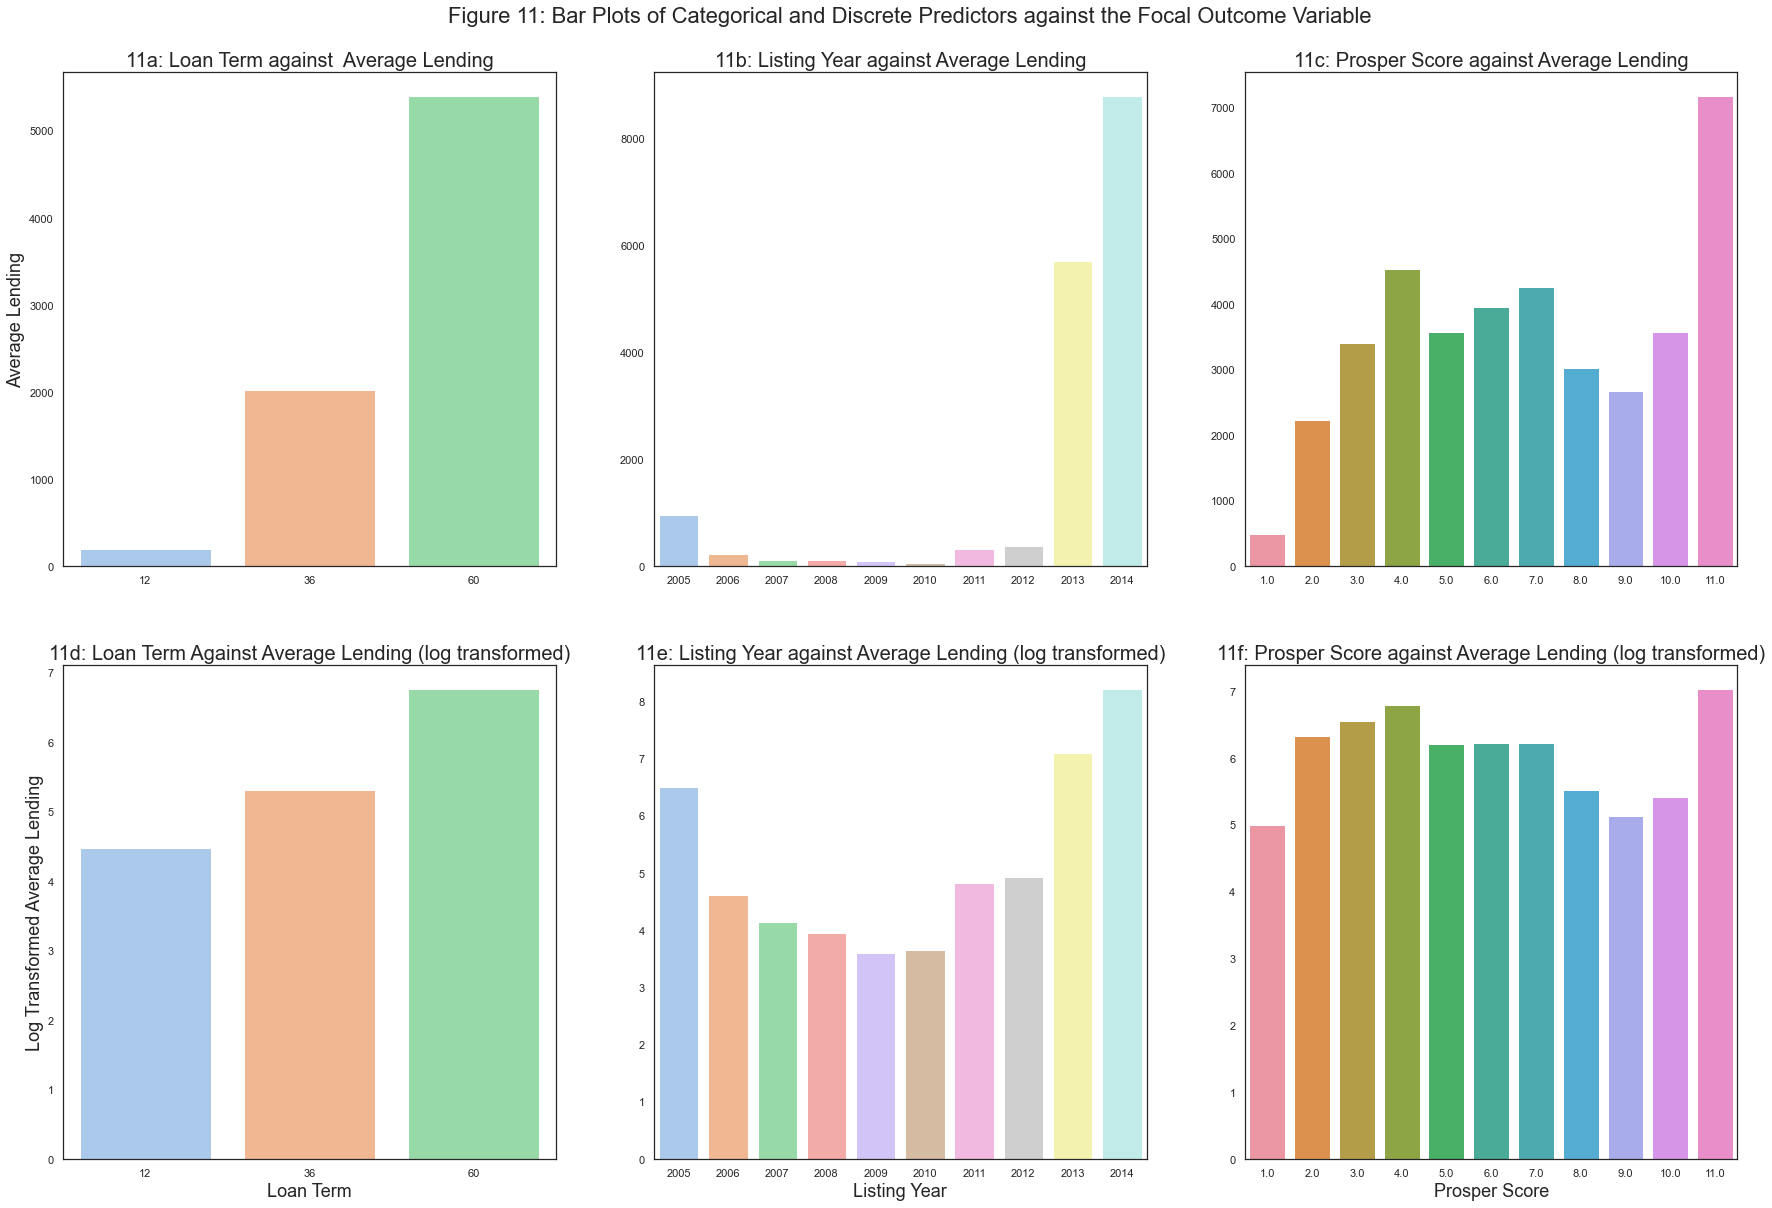

In [308]:
#create a subplot and add a common title
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = [30,20])
plt.text(-8,17, 'Figure 11: Bar Plots of Categorical and Discrete Predictors against the Focal Outcome Variable', fontsize = 22, ha = 'center')

#draw bar plots
def Bar2(x_var, y_var,i,j):
    sns.barplot(data = df_exp2, x = x_var, y = y_var, ci = None, ax = ax[i,j])
    
Bar2('Term','AverageLending',0,0)
Bar2('ListingYear','AverageLending',0,1)
Bar2('ProsperScore','AverageLending',0,2)

Bar2('Term','AverageLending_log',1,0)
Bar2('ListingYear','AverageLending_log',1,1)
Bar2('ProsperScore','AverageLending_log',1,2)

#add subtitles
ax[0,0].set_title('11a: Loan Term against  Average Lending',fontsize = 20)
ax[0,1].set_title('11b: Listing Year against Average Lending',fontsize = 20)
ax[0,2].set_title('11c: Prosper Score against Average Lending',fontsize = 20)
ax[1,0].set_title('11d: Loan Term Against Average Lending (log transformed)',fontsize = 20)
ax[1,1].set_title('11e: Listing Year against Average Lending (log transformed)',fontsize = 20)
ax[1,2].set_title('11f: Prosper Score against Average Lending (log transformed)',fontsize = 20)

#add x axis labels
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[1,0].set_xlabel('Loan Term',fontsize = 18)
ax[1,1].set_xlabel('Listing Year', fontsize = 18)
ax[1,2].set_xlabel('Prosper Score', fontsize = 18)

#add y axis labels
ax[0,0].set_ylabel('Average Lending', fontsize = 18)
ax[1,0].set_ylabel('Log Transformed Average Lending', fontsize = 18)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,2].set_ylabel('')
ax[0,2].set_ylabel('')

plt.show()

### Virsualizaton 12: Volin Plots of Categorical and Discrete Predictors against the Focal Outcome Variable 

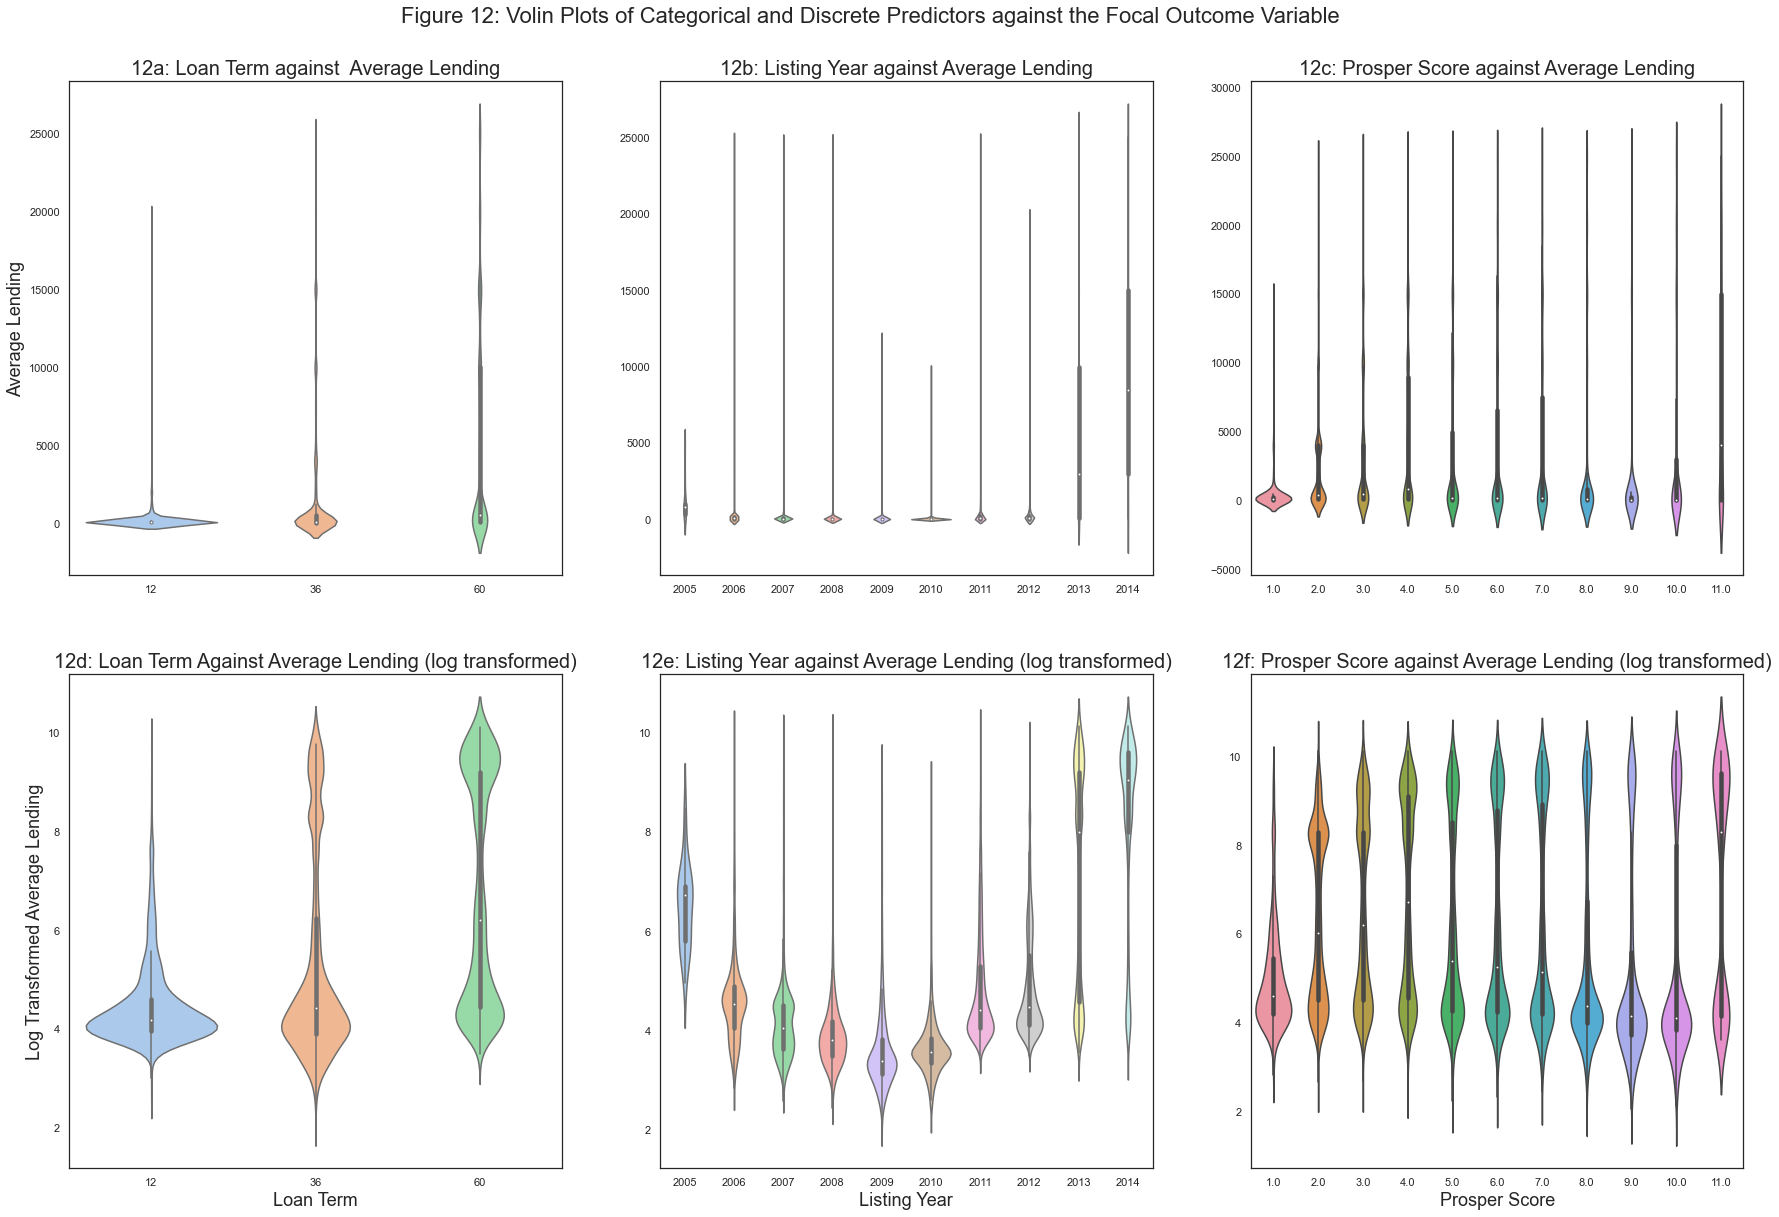

In [57]:
#Figure 12 volin plots of the categorical predictors (i.e., Term, ListingYear) against raw and log transformed AverageLending

#create a supplot and add a common title
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = [30,20])
plt.text(-9,26.5, 'Figure 12: Volin Plots of Categorical and Discrete Predictors against the Focal Outcome Variable', fontsize = 22, ha = 'center')

#draw subplots
def Volin(x_var, y_var,i,j):
    sns.violinplot(data = df_exp2, x = x_var, y = y_var, ax = ax[i,j])
    
Volin('Term','AverageLending',0,0)
Volin('ListingYear','AverageLending',0,1)
Volin('ProsperScore','AverageLending',0,2)

Volin('Term','AverageLending_log',1,0)
Volin('ListingYear','AverageLending_log',1,1)
Volin('ProsperScore','AverageLending_log',1,2)

#add subtitles
ax[0,0].set_title('12a: Loan Term against  Average Lending',fontsize = 20)
ax[0,1].set_title('12b: Listing Year against Average Lending',fontsize = 20)
ax[0,2].set_title('12c: Prosper Score against Average Lending',fontsize = 20)
ax[1,0].set_title('12d: Loan Term Against Average Lending (log transformed)',fontsize = 20)
ax[1,1].set_title('12e: Listing Year against Average Lending (log transformed)',fontsize = 20)
ax[1,2].set_title('12f: Prosper Score against Average Lending (log transformed)',fontsize = 20)

#add x axis labels
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[1,0].set_xlabel('Loan Term',fontsize = 18)
ax[1,1].set_xlabel('Listing Year', fontsize = 18)
ax[1,2].set_xlabel('Prosper Score', fontsize = 18)

#add y axis labels
ax[0,0].set_ylabel('Average Lending', fontsize = 18)
ax[1,0].set_ylabel('Log Transformed Average Lending', fontsize = 18)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,2].set_ylabel('')
ax[0,2].set_ylabel('')

plt.show()

In [92]:
# check the summary despcritives
df_exp[['AverageLending','Term']].groupby(['Term']).describe().T

Term                            12            36            60
AverageLending count   1579.000000  85442.000000  23558.000000
               mean     194.052757   2030.908267   5407.163493
               std      787.856180   4552.110628   7219.016263
               min       12.820513      7.299270     32.649254
               25%       52.083333     49.382716     85.621169
               50%       65.217391     83.333333    500.000000
               75%      100.926932    521.739130  10000.000000
               max    20000.000000  25000.000000  25000.000000

In [93]:
df_exp[['AverageLending','ListingYear']].groupby(['ListingYear']).describe().T

ListingYear                  2005          2006          2007          2008  \
AverageLending count    21.000000   6180.000000  11452.000000  11051.000000   
               mean    954.051927    224.550475    125.987968    123.233014   
               std    1029.267372    879.649128    660.650708    704.139234   
               min     142.857143     14.705882     12.765957     10.148515   
               25%     333.333333     57.465150     37.413629     32.258065   
               50%     833.333333     93.750000     57.142857     44.638393   
               75%    1000.000000    134.615385     91.743119     65.217391   
               max    4800.000000  25000.000000  25000.000000  24999.000000   

ListingYear                   2009          2010          2011          2012  \
AverageLending count   2094.000000   5418.000000  10637.000000  19155.000000   
               mean      96.964760     57.178889    316.681156    372.494790   
               std      524.406664    246.841418    847.181912   1120.976927   
               min        7.299270      8.196721     32.258065     32.258065   
               25%       22.344520     28.037383     57.142857     61.224490   
               50%       29.324647     35.162064     81.521739     88.235294   
               75%       45.454545     46.498765    200.000000    250.000000   
               max    12000.000000  10000.000000  25000.000000  20000.000000   

ListingYear                   2013          2014  
AverageLending count  34280.000000  10291.000000  
               mean    5700.341825   8801.533323  
               std     6762.918643   7033.939020  
               min       34.482759     36.585366  
               25%       96.774194   3000.000000  
               50%     3000.000000   8500.000000  
               75%    10000.000000  15000.000000  
               max    25000.000000  25000.000000

In [94]:
df_exp[['AverageLending','ProsperScore']].groupby(['ProsperScore']).describe().T

ProsperScore                  1.0           2.0           3.0           4.0   \
AverageLending count    919.000000   5643.000000   7464.000000  12251.000000   
               mean     496.776248   2239.023977   3408.694797   4544.646880   
               std     1511.785258   3296.078251   4851.183295   5966.860922   
               min       16.393443     13.888889     14.285714     12.048193   
               25%       65.615168     90.364725     90.909091     95.238095   
               50%      100.000000    416.666667    500.000000    833.333333   
               75%      235.294118   4000.000000   4000.000000   9000.000000   
               max    15000.000000  25000.000000  25000.000000  25000.000000   

ProsperScore                  5.0           6.0           7.0           8.0   \
AverageLending count   9541.000000  11906.000000  10215.000000  11501.000000   
               mean    3571.834460   3959.639173   4256.307234   3022.505051   
               std     5831.416783   6294.611788   6646.209392   6167.174137   
               min        8.849558      9.933775     11.111111      8.000000   
               25%       71.604938     68.965517     65.729115     53.763441   
               50%      219.298246    190.174804    172.413793     80.000000   
               75%     5000.000000   6588.250000   7500.000000    842.105263   
               max    25000.000000  25000.000000  25000.000000  25000.000000   

ProsperScore                  9.0           10.0          11.0  
AverageLending count   6601.000000   4488.000000   1332.000000  
               mean    2679.726721   3580.015514   7185.615682  
               std     5934.025946   6756.878001   8075.962853  
               min        7.299270      8.000000     36.585366  
               25%       41.237113     46.544108     64.102564  
               50%       62.827225     61.224490   4000.000000  
               75%      269.230769   3000.000000  15000.000000  
               max    25000.000000  25000.000000  25000.000000

### Observation 11-12: The box plots and violin plots show that 
#### 1. Suprisingly, the longer the ```Term``` of a loan, the more the```AverageLending```. The variance of ```AverageLending``` also increases as the term increases.
#### 2. Interestingly, the relationship between ```ListingYear``` and  ```AverageLending``` follows a U-shaped pattern from 2005 to 2014 -- it decreased from 2005 to 2010 and dramatically increased since 2010.
#### 3. Treating ```ProsperScore```as a discrete variable reveals more nuanced relationship between it and ```AverageLending``` : there is a positive relationship when prosper score is relative low (1-4) and almost no relationship when it is in the middle (5-7) and regain a general positive relationship when it is high (8-11).

### Question 13-14: what are the listing pattern across states and year?

### Virsualization 13: The Trend in the Number of Listings by States

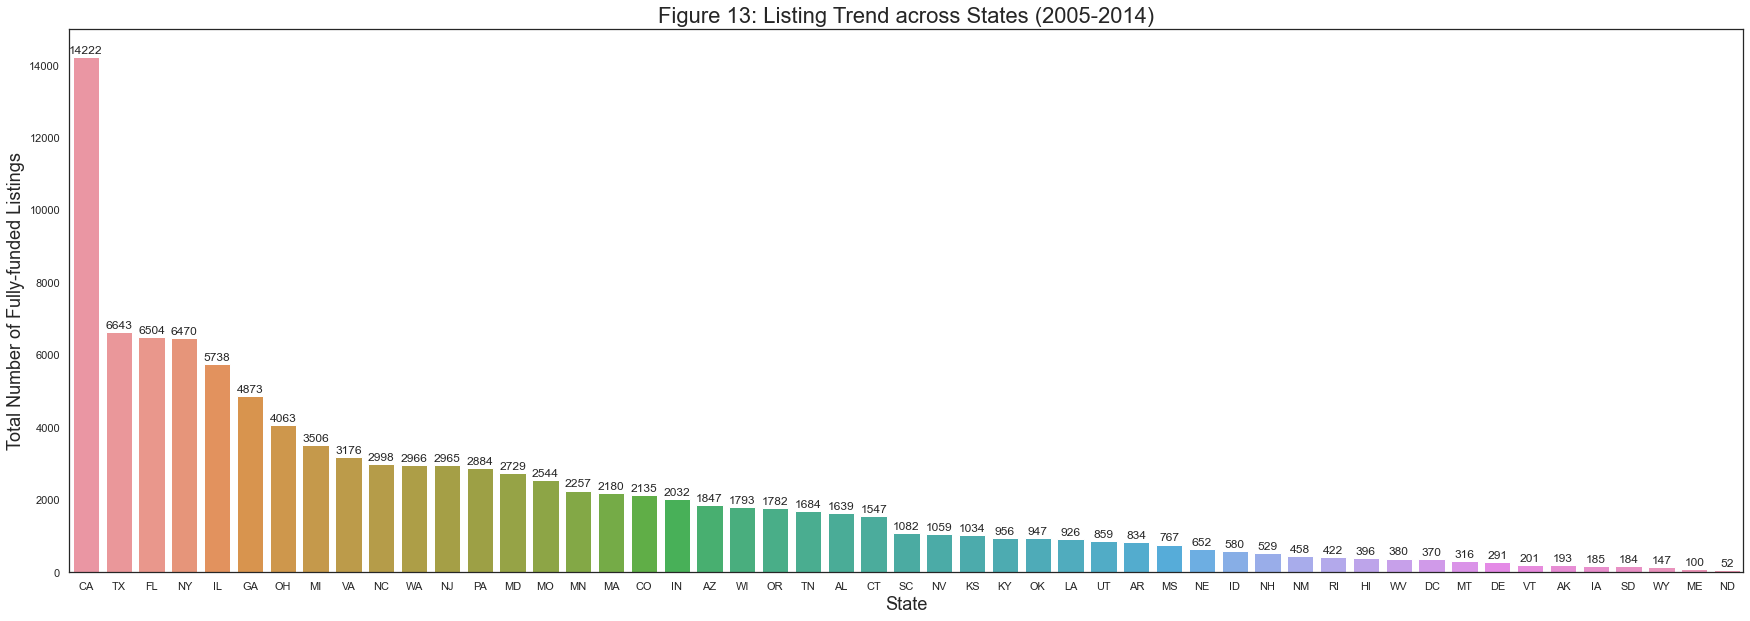

In [95]:
# Figure 13: bar plot for distribution of the number of listings by states

df_temp2 = df_exp['BorrowerState'].value_counts().rename_axis('State').reset_index(name='Counts')

plt.figure(figsize=[30, 10])
plt.title('Figure 13: Listing Trend across States (2005-2014)', fontsize = 22)

ax = sns.barplot(x = 'State', y = 'Counts', data = df_temp2)

plt.xlabel('State', fontsize = 18)
plt.ylabel('Total Number of Fully-funded Listings', fontsize = 18)

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+100,
            s = '{:.0f}'.format(height),
            fontsize= 12,
            ha = 'center') 

plt.ylim(0,15000)

plt.show()

### Virsualization 14: Distribution of the Number of Listings by Year

In [96]:
# Figure 14: line plot for the listing trend by year

##before drawing the graph, create a data for estimated listings of 2014
df_temp3 = df_exp['ListingYear'].value_counts().rename_axis('Year').reset_index(name='Counts').sort_values('Year')

##drop year 2005 and 2014 because listing information in the two years is not fully recorded in both years (only partial November and December in 2005 and January, Feburary and partial March in 2014)
df_temp4 = df_temp3.drop(df_temp3.loc[(df_temp3['Year']==2005)|(df_temp3['Year']==2014)].index).reset_index().drop(columns=['index'])

##add the estimation of 2014 (codes see the next line) to the line chart
df_temp5 = df_temp4.copy()
df_temp5['Type'] = 'Actual'
df_temp5.loc[len(df_temp4.index)] = [2014,52904, 'Estimated'] ## =10291/71*365
df_temp5.loc[len(df_temp4.index)+1] = [2013,34280, 'Estimated'] 
df_temp5.sort_values('Year',inplace =True)

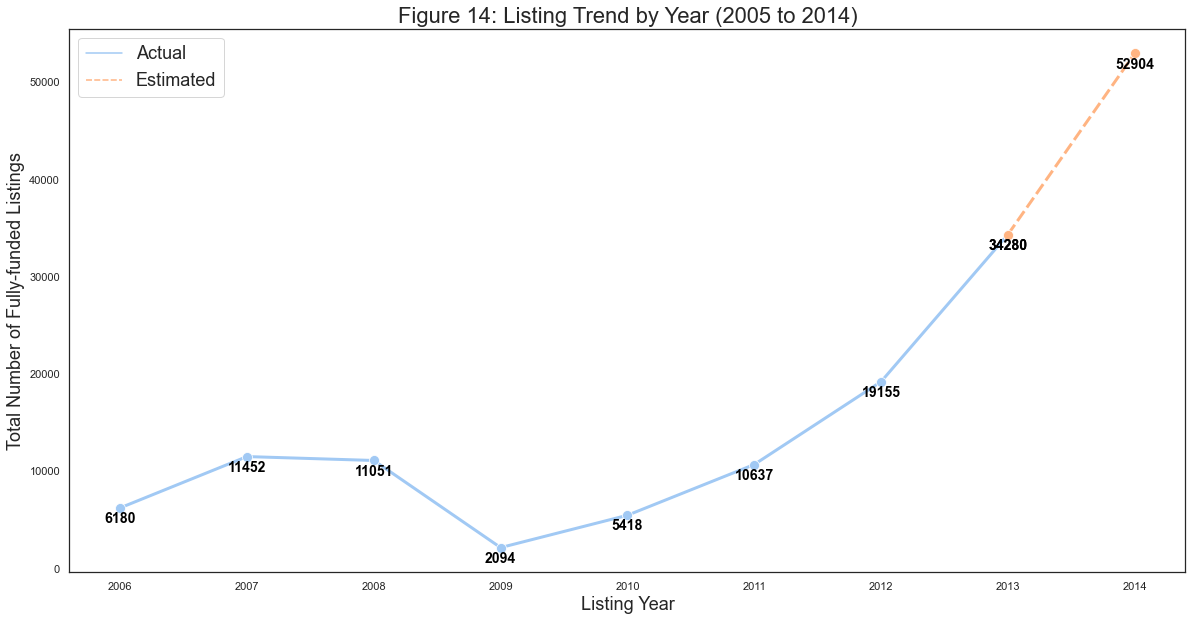

In [108]:
#draw the line plot
plt.figure(figsize = [20,10])
plt.title('Figure 14: Listing Trend by Year (2005 to 2014)',fontsize = 22)

sns.lineplot(data = df_temp5, x = 'Year', y = 'Counts', hue = 'Type', style = 'Type',  linewidth = 3 , marker = '.', markersize = 20)

#add labels and legends
plt.xlabel('Listing Year', fontsize = 18)
plt.ylabel('Total Number of Fully-funded Listings', fontsize = 18)
plt.legend(fontsize = 18)

##add datapoint labels
for x, y in zip(df_temp5['Year'], df_temp5['Counts']):
    plt.text(x = x, y = y-1500, s = '{:.0f}'.format(y), color = 'black',fontweight='bold', fontsize = 14, ha = 'center') 

plt.show()

In [99]:
# calculations:
p1 = df_temp2.Counts[0:5].sum()/df_temp2.Counts.sum()
print('the listings of top 5 states account for', "{0:.0%}".format(p1), 'of the total listings from 2005 to 2014')

print('')

p2 = df_temp3.query('Year == 2013').Counts.sum()/df_temp3.Counts.sum()
print('the listings of 2013 account for', "{0:.0%}".format(p2), 'of the total listings across all states')

print('')

n3 = df_temp3.query('Year == 2014').Counts.sum()/((31+28+12)/365)
print('the estimated total listings of 2014 is', n3)

the listings of top 5 states account for 38% of the total listings from 2005 to 2014

the listings of 2013 account for 31% of the total listings across all states

the estimated total listings of 2014 is 52904.43661971831


### Observation 13-14:
#### 1. California had the largeest number of listings from 2005 to 2014 (N = 14,222), more than double than the state with the second largest number of listings -- Texas (N = 6,737). Followed by California and Texas, Floria (N = 6,504), New York State (N = 6,470) and Illinois (N = 5,738) were the states with over 5,000 listings in total.In addition, the total listings of the five states account for 38% of the total listings accorss all states. In other words, p2p lending were most popular in these states , which also were and are still the states with the highest GDP (CA > TX > NY > FL > IL).

#### 2. The total number of listings increased by 4 times from 2006 (N = 6,180) to 2013 (N = 34280). In addition, the total listings of 2013 account for 31% of the total listings accorss all states. It also shows a general linear trend desipite a short drop in 2009 (which chould be due to Financial crisis of 2007–2008). Furthermore, the first 71 days of 2014 saw 10,485 listings already, suggesting a larger number of listings for the full year (estimated to be 52,904), compared to that in 2013.

## Findings of Bivariate Exploration

### 1. Correlation plots (Figure 9), scatter plots (Figure 10), box plots (Figure 11) and volin plots (Figure 12) provide preliminary virsual test for the a-priori predictions in that:
#### 1.1. Borrower's ```ProsperScore```, which is an integrated metric of the borrower's credibility and realibility, has a nuanced relationship with ```AverageLending``` in that there is a positive relationship when prosper score is relative low (1-4) and almost no relationship when it is in the middle (5-7) and regain a general positive relationship when it is high (8-11) - more complicated than the prediction.
#### 1.2. Borrower's ```StatedMonthlyIncome```, which suggests the borrower's payment ability, indeed has a positive effect on ```AverageLending``` - consistent with the prediction.
#### 1.3. Lender's ```LenderYield```, which indicates expected financial return on lender's investment on a loan listing, surprisingly has a weak negative impact on ```AverageLending``` - partly consistent with the prediction.
#### 1.4. Loan's ```Term```, which affects rate of return and investment return period, is negatively related to ```AverageLending``` (the longer term, the more average lendng) - opposite to  the prediction.
#### 1.5. Loan's ```LoanDuration``` indeed negatively correlates with ```AverageLending```, possibly because the longer a list has been listed, the more risk investors may associate with the listing due to others' non-investing behaviors - consistent with the prediction.
#### 1.6.  Loan's```Listingyear```, interestingly has a U-shaped relationship with ```AverageLending``` in that it decreased from 2005 to 2010 and dramatically increased since 2010 - inconsistent with the prediction.

### 2. The trends in number of listings across states and years are in line with the predictions that:
#### 2.1. P2p lending is most popular in states with better econmies  (in terms of GDP, CA > TX > NY > FL > IL).
#### 2.2. P2p lending became more popular in recent years especially after 2009. The sudden drop in 2009 was possibly due to the Financial crisis of 2007–2008

### 3. Next, I will explore possible interactions between predictors for deeper investigations.

## Multivariate Exploration

### Question 15: How does ```ProsperScore``` interact with ```StatedMonthlyIncome```, both indicating the borrower's reliability and ability of payoff and thus affecting ```AverageLendingAmount```?

In [188]:
#Create categorical ProsperScore, because it has 11 levels and it is hard to interpret if all 11 levels are used
#Low Score = 1-4,
#Medium Score =  5-7,
#Low Score = 8-11
df_exp2['ProsperScore'].describe()

count    81861.000000
mean         5.927071
std          2.368673
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         11.000000
Name: ProsperScore, dtype: float64

In [315]:
#Therefore, low score = 1-4, med score = 5-7, high score = 8-11
Coding = []
for i in df_exp2['ProsperScore']:
    if i <=4:
        Coding.append('Low')
    elif i == 5 or i == 6 or i == 7:
        Coding.append('Med')
    elif i>=8:
        Coding.append('High')
    else:
        Coding.append('NA')

In [316]:
df_exp2['ProsperScore_coded'] = Coding

In [317]:
df_exp2['ProsperScore_coded'].value_counts()

Med     31662
NA      28718
Low     26277
High    23922
Name: ProsperScore_coded, dtype: int64

### Visualization 15: Regression Plot of the Interaction Between Stated Monthly Income and Prosper Score on Average Lending

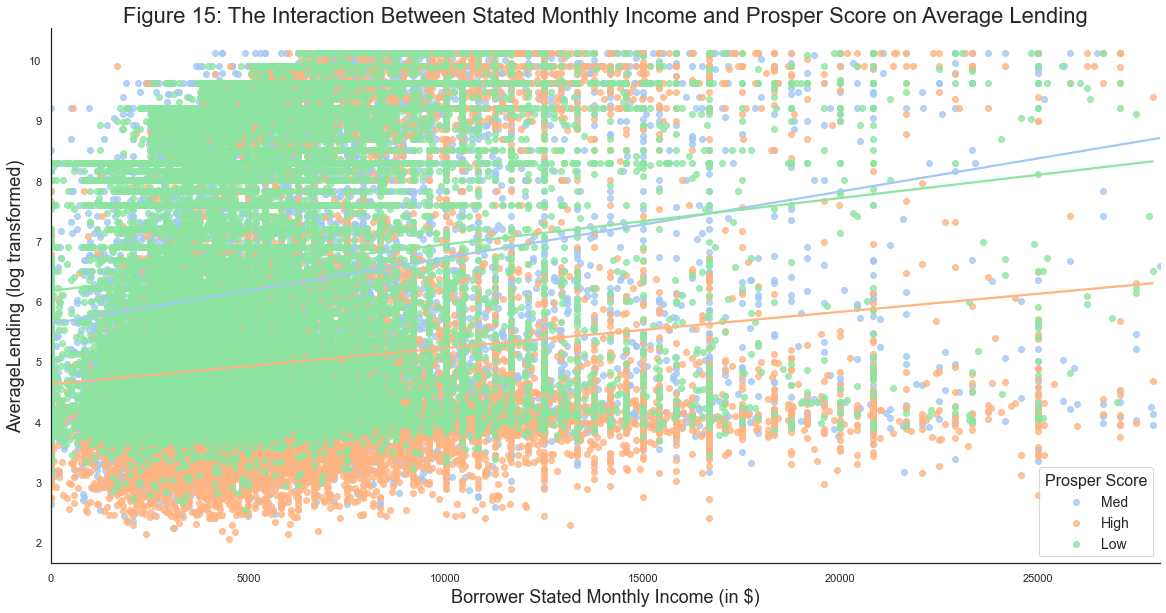

In [318]:
#excluding listings without ProsperScore


sns.lmplot(data = df_exp2.query('ProsperScore_coded != "NA"'), x = 'StatedMonthlyIncome', y = 'AverageLending_log', hue = 'ProsperScore_coded' ,
           robust = True, ci = None, legend = False, 
           height=8, aspect=2)

plt.title('Figure 15: The Interaction Between Stated Monthly Income and Prosper Score on Average Lending', fontsize = 22)

#add labels and lengends
plt.xlabel('Borrower Stated Monthly Income (in $)',fontsize = 18)
plt.ylabel('AverageLending (log transformed)',fontsize = 18)
plt.legend(title = 'Prosper Score', fontsize = 14, title_fontsize = 16)

plt.show()

In [319]:
#supplementary stat analysis - Robust Linear Regression
from statsmodels.formula.api import rlm
m1 = rlm('AverageLending_log ~ ProsperScore_coded*StatedMonthlyIncome', data=df_exp2.query('ProsperScore_coded != "NA"')).fit() 
print(m1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:     AverageLending_log   No. Observations:                81861
Model:                            RLM   Df Residuals:                    81855
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 27 Aug 2022                                         
Time:                        12:57:23                                         
No. Iterations:                    16                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [320]:
#supplementary stat analysis2 - ANOVA
from statsmodels.formula.api import ols
m2= ols('AverageLending_log ~ C(ProsperScore_coded)*StatedMonthlyIncome', data=df_exp2.query('ProsperScore_coded != "NA"')).fit()
sm.stats.anova_lm(m2, typ=2)

,sum_sq,df,F,PR(>F)
C(ProsperScore_coded),18995.445687,2.0,1954.058157,0.000000e+00
StatedMonthlyIncome,7282.450965,1.0,1498.288900,0.000000e+00
C(ProsperScore_coded):StatedMonthlyIncome,210.253034,2.0,21.628693,4.066860e-10
Residual,397857.198232,81855.0,NaN,NaN


### Observation 15: 
#### 1. The regression plot and the auxiliary regression analyses show there is a significant interaction between Borrower's ```StatedMonthlyIncome``` and ```ProsperScore``` on ```AverageLending```. 
#### 2. Specifically, Borrower's ```StatedMonthlyIncome``` has a stronger positive influence on ```AverageLending``` for borrowers with a high (vs. med) ```ProsperScore```.

### Question 16: How does ```ProsperScore``` interact with ```LenderYield```, which indicating potential risk (the lower score, the higher risk) and potential return respectively, and thus affecting ```AverageLendingAmount```?

### Visualization 16: Regression Plot of the Interaction Between Lender Yield and Prosper Score on Average Lending

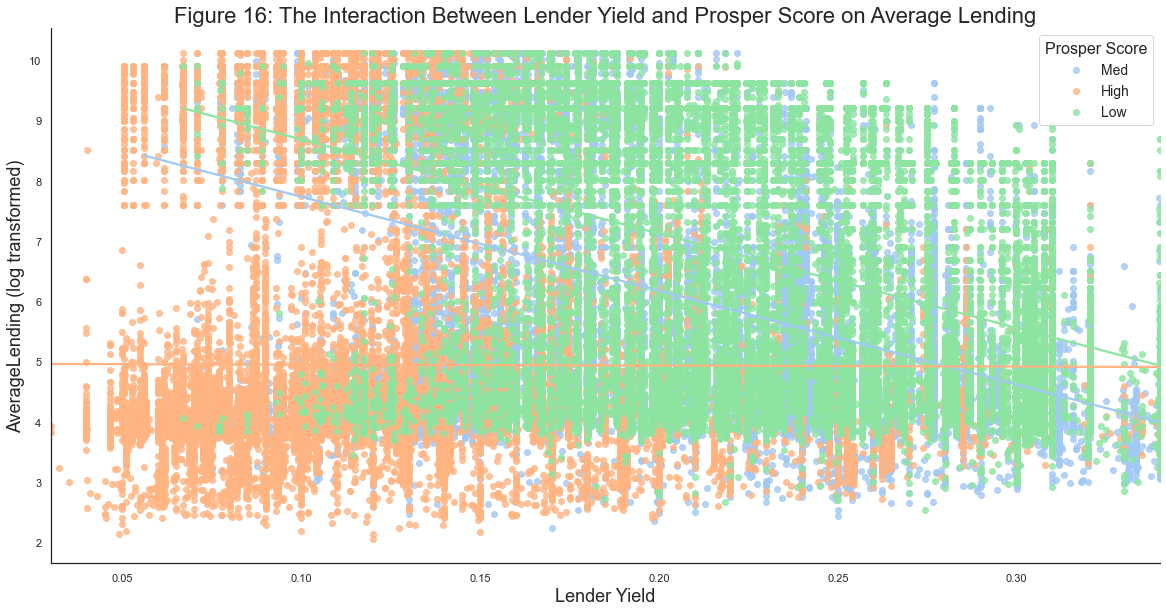

In [322]:
#excluding listings without ProsperScore


sns.lmplot(data = df_exp2.query('ProsperScore_coded != "NA"'), x = 'LenderYield', y = 'AverageLending_log', hue = 'ProsperScore_coded' ,
           ci = None, robust = True, legend = False,
           height=8, aspect=2)

plt.title('Figure 16: The Interaction Between Lender Yield and Prosper Score on Average Lending', fontsize = 22)

#add labels and lengends
plt.xlabel('Lender Yield',fontsize = 18)
plt.ylabel('AverageLending (log transformed)',fontsize = 18)
plt.legend(title = 'Prosper Score', fontsize = 14, title_fontsize = 16)

plt.show()

In [323]:
#supplementary stat analysis3 - Robust Linear Regression
from statsmodels.formula.api import rlm
m3 = rlm('AverageLending_log ~ ProsperScore_coded*LenderYield', data=df_exp2.query('ProsperScore_coded != "NA"')).fit() 
print(m3.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:     AverageLending_log   No. Observations:                81861
Model:                            RLM   Df Residuals:                    81855
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 27 Aug 2022                                         
Time:                        12:59:27                                         
No. Iterations:                    35                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [324]:
#supplementary stat analysis4 - ANOVA
from statsmodels.formula.api import ols
m4= ols('AverageLending_log ~ C(ProsperScore_coded)*LenderYield', data=df_exp2.query('ProsperScore_coded != "NA"')).fit()
sm.stats.anova_lm(m4, typ=2)

,sum_sq,df,F,PR(>F)
C(ProsperScore_coded),51408.130470,2.0,5973.008158,0.0
LenderYield,44613.328284,1.0,10367.067285,0.0
C(ProsperScore_coded):LenderYield,8484.207270,2.0,985.763123,0.0
Residual,352252.366676,81855.0,NaN,NaN


### Observation 16: 

#### 1. The regression plot and the auxiliary regression analyses show there is a significant interaction between ```LenderYield``` and ```ProsperScore``` on ```AverageLending```. 
#### 2. Interestingly, ```LenderYield``` has significant negative effects on ```AverageLending``` when borrowers have low and med ```ProsperScore```; however, it has not effect on ```AverageLending``` when borrowers have high ```ProsperScore```.

### Question 17: How does ```Term``` interact with ```LenderYield```, both influencing return of investment rate and thus affecting ```AverageLendingAmount```?

### Visualization 17: Regression Plot of the Interaction Between Lender Yield and Term on Average Lending

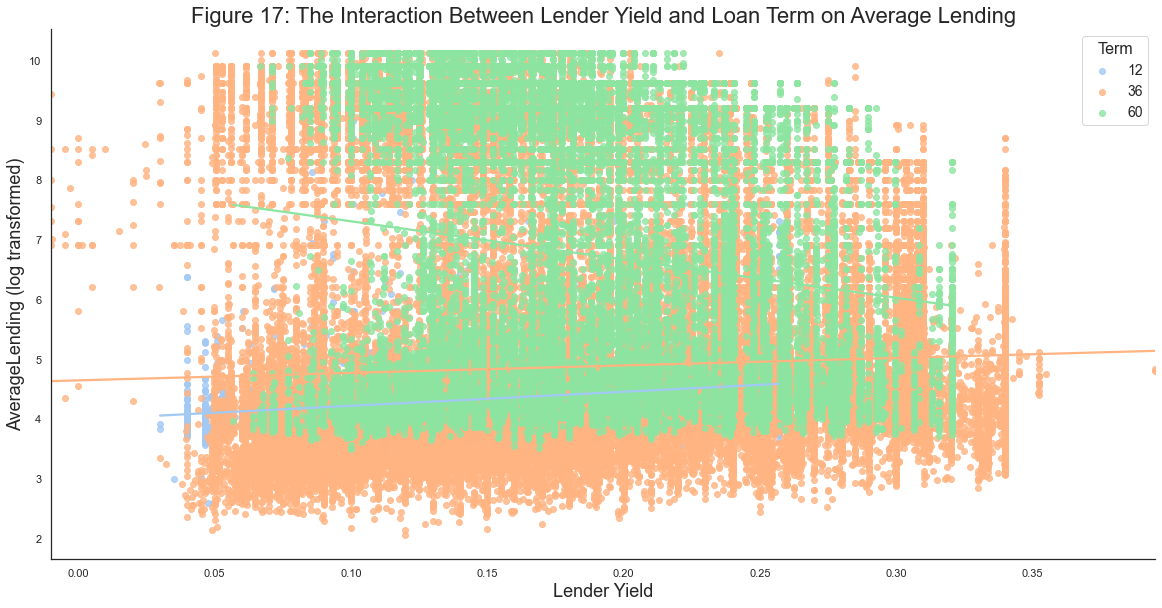

In [284]:
sns.lmplot(data = df_exp2, x = 'LenderYield', y = 'AverageLending_log', hue = 'Term' ,
           ci = None, robust = True, legend = False,
           height=8, aspect=2)

plt.title('Figure 17: The Interaction Between Lender Yield and Loan Term on Average Lending', fontsize = 22)

#add labels and lengends
plt.xlabel('Lender Yield',fontsize = 18)
plt.ylabel('AverageLending (log transformed)',fontsize = 18)
plt.legend(title = 'Term', fontsize = 14, title_fontsize = 16)

plt.show()

In [275]:
#supplementary stat analysis5 - Robust Linear Regression
from statsmodels.formula.api import rlm
m5 = rlm('AverageLending_log ~ C(Term)*LenderYield', data=df_exp2).fit() 
print(m5.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:     AverageLending_log   No. Observations:               110579
Model:                            RLM   Df Residuals:                   110573
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 26 Aug 2022                                         
Time:                        13:46:13                                         
No. Iterations:                    34                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [276]:
#supplementary stat analysis4 - ANOVA
from statsmodels.formula.api import ols
m6= ols('AverageLending_log ~ C(Term)*LenderYield', data=df_exp2).fit()
sm.stats.anova_lm(m6, typ=2)

,sum_sq,df,F,PR(>F)
C(Term),41563.032807,2.0,4818.559342,0.000000e+00
LenderYield,1658.405473,1.0,384.530418,1.795727e-85
C(Term):LenderYield,2013.328964,2.0,233.412829,6.973992e-102
Residual,476880.007063,110573.0,NaN,NaN


In [321]:
#save the data for Part II
df_exp2.to_csv('df_exp2.csv')

### Observation 17: 
#### 1. The regression plot and the auxiliary regression analyses show there is a significant interaction between ```LenderYield``` and ```Term``` on ```AverageLending```. 
#### 2. Specifically, ```LenderYield``` has a negative effect on ```AverageLending``` when ```Term``` is 60 months; however, it has weak positive effects on ```AverageLending``` when ```Term``` is 12 or 36 months.

## Findings of Multivariate Exploration

### 1. Regression plots (Figure 15 - 17) as well as auxiliary regression analyses suppor the hypothesized interactions.
#### 1.1. There is a significant interaction between ```ProsperScore``` and ```StatedMonthlyIncome```, both suggesting borrowers' credibility; specifically, borrower's ```StatedMonthlyIncome``` has a stronger positive influence on ```AverageLending``` for borrowers with a high (vs. med) ```ProsperScore```.
#### 1.2. There is a significant interaction between ```ProsperScore``` and ```LenderYield```, which reflecting a tradeoff between risk and return of the investment for lenders; interestingly, ```LenderYield``` has significant negative effects on ```AverageLending``` when borrowers have low and med ```ProsperScore```; however, it has not effect on ```AverageLending``` when borrowers have high ```ProsperScore```.
#### 1.3. There is a significant interaction between ```Term``` and ```LenderYield```, both suggesting lenders' ROI rate; specifically, ```LenderYield``` has a negative effect on ```AverageLending``` when ```Term``` is 60 months; however, it has no effects on ```AverageLending``` when ```Term``` is 12 or 36 months.

## Conclusions

### The dataset is retrieved from Prosper.come API. After data wrangling, there are 112,196 unique fully-funded Prosper loan listings created and funded between Nov. 2005 and March 2014 in 51 US states and Washington DC. The exploration has two major goals. First, it aims to investigate the antedecants of lender's average lending for each listing, which is calculated as ```LoanOriginalAmount``` divided by ```Investors``` and reflects lender's contribution to p2p lending, a critical metrics p2p lending platforms are interested in. Second, it aims to examine the listing distribution across years and states, which may reflect the popularity of p2p lending regionally and historically.

### Univariate, bivariate and multivariate explorations show that:
#### 1) Borrower's ```ProsperScore```, which is an integrated metric of the borrower's credibility and realibility, has a nuanced relationship with ```AverageLending``` in that there is a positive relationship when prosper score is relative low (1-4) and almost no relationship when it is in the middle (5-7) and regain a general positive relationship when it is high (8-11) - more complicated than the prediction.
#### 2) Borrower's ```StatedMonthlyIncome```, which suggests the borrower's payment ability, has a suprisingly negative effect on ```AverageLending```.
#### 3) Lender's ```LenderYield```, which indicates expected financial return on lender's investment on a loan listing, has a suprisingly negative effect on ```AverageLending```.¶
#### 4) Loan's ```Term```, which affects rate of return and investment return period, is negatively related to ```AverageLending``` (i.e., the longer term (e.g., 60 months vs. 12 months), the more average lendng).
#### 5) Loan's ```LoanDuration```, which implies other lenders' behaviors (e.g., the longer duration, the less willing other lenders to lend), is negatively correlates with ```AverageLending```.
#### 6) Loan's ```Listingyear```, interestingly has a U-shaped relationship with ```AverageLending``` in that it decreased from 2005 to 2010 and dramatically increased since 2010 - inconsistent with the prediction.
#### 7) There is a significant interaction between ```ProsperScore``` and ```StatedMonthlyIncome```, both suggesting borrowers' credibility; specifically, borrower's ```StatedMonthlyIncome``` has a stronger positive influence on ```AverageLending``` for borrowers with a high (vs. med) ```ProsperScore```.
#### 8) There is a significant interaction between ```ProsperScore``` and ```LenderYield```, which reflecting a tradeoff between risk and return of the investment for lenders; interestingly, ```LenderYield``` has significant negative effects on ```AverageLending``` when borrowers have low and med ```ProsperScore```; however, it has no effect on ```AverageLending``` when borrowers have high ```ProsperScore```.
#### 9) There is a significant interaction between ```Term``` and ```LenderYield```, both suggesting lenders' ROI rate; specifically, ```LenderYield``` has a negative effect on ```AverageLending``` when ```Term``` is 60 months; however, it has no effects on ```AverageLending``` when ```Term``` is 12 or 36 months.
#### 10) P2p lending is more popular in states with better econmies (in terms of GDP, CA > TX > NY > FL > IL).
#### 11) P2p lending became more popular in recent years especially after 2009. The sudden drop in 2009 was possibly due to the Financial crisis of 2007–2008.